# Introduction
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become cancer, with melanoma being the deadliest skin cancer. Its incidence has increased during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for skin cancer detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).

## Goal of the challenge
The goal of this challenge is to classify dermoscopic images of skin lesions among eight different diagnostic classes:
1. Melanoma
2. Melanocytic nevus
3. Basal cell carcinoma
4. Actinic keratosis
5. Benign keratosis
6. Dermatofibroma
7. Vascular lesion
8. Squamous cell carcinoma
In order to do that, you will extract features such as the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (usually called the ABCD rule). After that, you will use machine learning algorithms to classify the images.

# Libraries

In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

In [29]:
from skimage.io import imread
from skimage.segmentation import chan_vese, watershed
from skimage.draw import ellipse
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from joblib import Parallel, delayed, parallel_backend

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

from skimage import io, color

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [19]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f'Error: {e}')

In [30]:
train_directory = './Train/Train'
test_directory = './Test/Test'

# Data
You will use a data-set of 25331 dermoscopic images of skin lesions with, when available, their relative segmentation and metadata (age, sex and anatomical position). Data has already been randomly split into a training-validation set (75%) and a test set (25%). You only have the classification (made by clinicians) of the training-validation set. The goal of the project is to estimate the correct class of each dermoscopic image in the test set. **You can only use the data provided in this challenge**



### Data Load

In [31]:
# Load the data
train_metadata = pd.read_csv('metadataTrain.csv')
test_metadata = pd.read_csv('metadataTest.csv')


In [32]:
# Load the images
train_images_filenames = os.listdir(train_directory)
test_images_filenames = os.listdir(test_directory)

train_images_filenames = sorted(train_images_filenames)
test_images_filenames = sorted(test_images_filenames)

train_images = []
train_masks = []
test_images = []
test_masks = []

train_dataset = []
test_dataset = []

for image in train_images_filenames:
    if image.endswith('_seg.png'):
        # Save the name without the _seg.png and the image
        name = image[:-8]
        image_name = name + '.jpg'
        mask_image = imread(train_directory + '/' + image)
        image_image = imread(train_directory + '/' + image_name)
        
        train_dataset.append([image_image, mask_image])

        train_masks.append([name, mask_image])
        
    else: 
        name = image[:-4]
        image_image = imread(train_directory + '/' + image)

        train_images.append([name, image_image])
    
   
for image in test_images_filenames:
    if image.endswith('_seg.png'):
        # Save the name without the _seg.png and the image
        name = image[:-8]
        image_name = name + '.jpg'
        mask_image = imread(test_directory + '/' + image)
        image_image = imread(test_directory + '/' + image_name)

        test_dataset.append([image_image, mask_image])

        test_masks.append([name, mask_image])
        
    else:
        name = image[:-4]
        image_image = imread(test_directory + '/' + image)

        test_images.append([name, image_image])

## Data Analysis

### Text Features

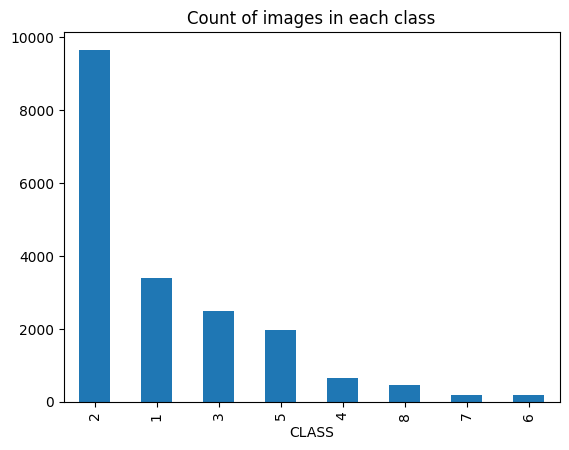

In [8]:
# Value counts of the classes
class_counts = train_metadata['CLASS'].value_counts()
class_counts.plot(kind='bar')

# Add legend
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Count of images in each class')
plt.show()

In [9]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        18998 non-null  object 
 1   CLASS     18998 non-null  int64  
 2   SEX       18714 non-null  object 
 3   AGE       18674 non-null  float64
 4   POSITION  17028 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 742.2+ KB


In [10]:
# Description of the data 
train_metadata.describe(include='object')

ID    SEX        POSITION
count          18998  18714           17028
unique         18998      2               8
top     ISIC_0028766   male  anterior torso
freq               1   9978            5194

In [11]:
train_metadata.describe()

CLASS           AGE
count  18998.000000  18674.000000
mean       2.568323     53.991914
std        1.532728     18.094209
min        1.000000      0.000000
25%        2.000000     40.000000
50%        2.000000     55.000000
75%        3.000000     70.000000
max        8.000000     85.000000

In [12]:
test_metadata.describe(include='object')

ID   SEX        POSITION
count           6333  6233            5672
unique          6333     2               8
top     ISIC_0055289  male  anterior torso
freq               1  3308            1721

In [13]:
test_metadata.describe()

AGE
count  6220.000000
mean     54.138264
std      18.241916
min       0.000000
25%      40.000000
50%      55.000000
75%      70.000000
max      85.000000

### Image Features

In [14]:
#Count images loaded
print(f'Number of training images: {len(train_images)}')
print(f'Number of training masks: {len(train_masks)}')

print(f'Number of testing images: {len(test_images)}')
print(f'Number of testing masks: {len(test_masks)}')
    

Number of training images: 18998
Number of training masks: 1945
Number of testing images: 6333
Number of testing masks: 648


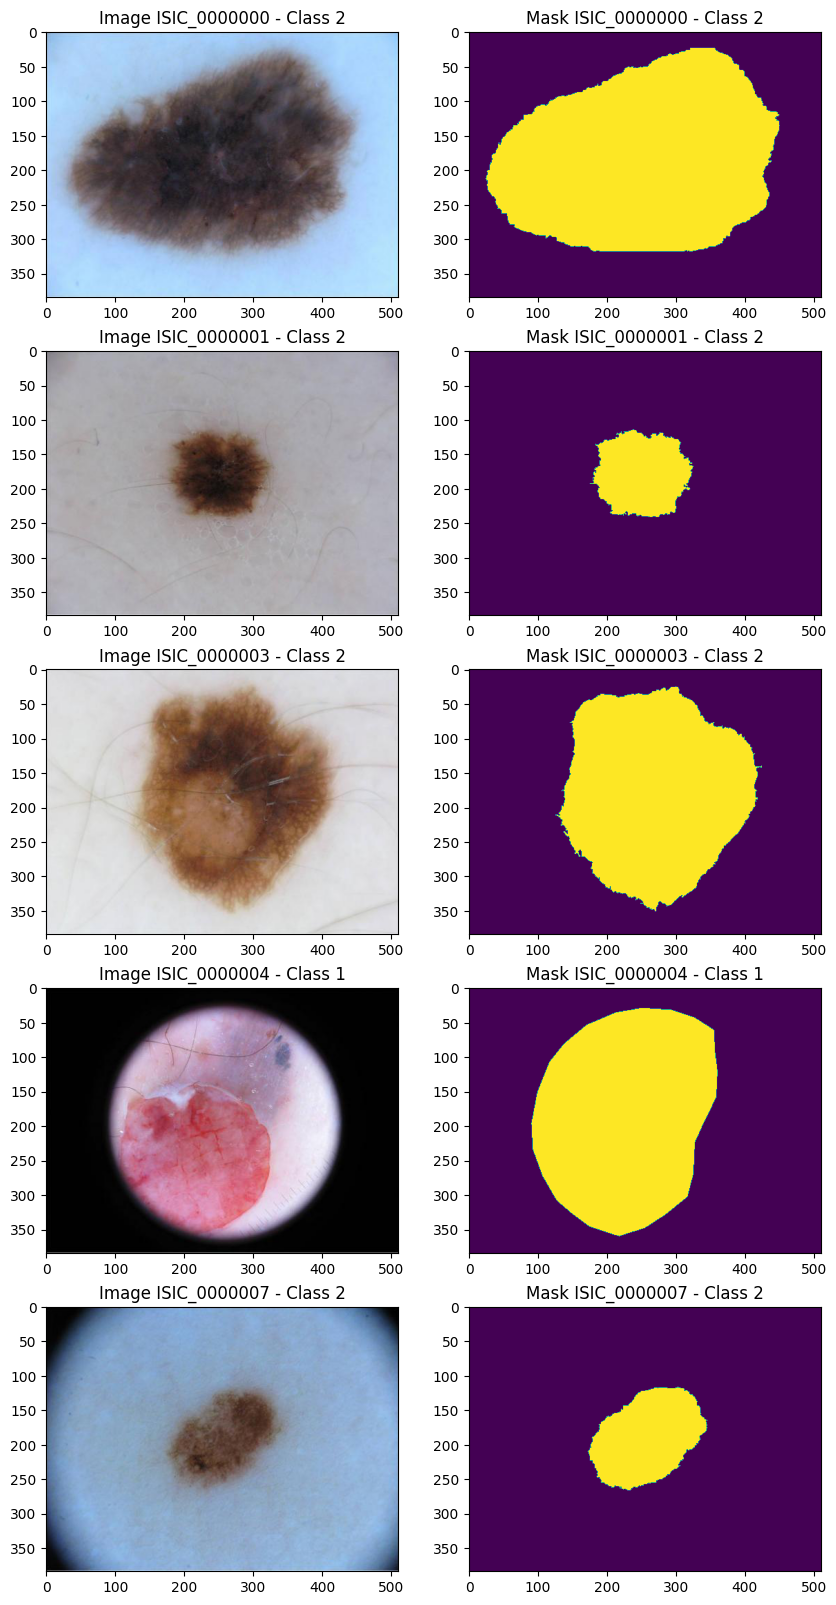

In [15]:
# Display a few images with the corresponding masks the corresponding masks have the same id as the image and their class

# Display the first 5 images
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

#get the first 5 masks
first_5_masks = [mask[0] for mask in train_masks[:5]]

j = 0
for i in first_5_masks:
    #Get the image
    image = next((item for item in train_images if item[0] == i), None)
    #Get the mask
    mask = next((item for item in train_masks if item[0] == i), None)
    
    #Get the class
    class_ = train_metadata[train_metadata['ID'] == i]['CLASS'].values[0]
    
    #Plot the image
    ax[j, 0].imshow(image[1])
    ax[j, 0].set_title(f'Image { image[0] } - Class {class_}')
    
    #Plot the mask
    ax[j, 1].imshow(mask[1])
    ax[j, 1].set_title(f'Mask {mask[0]} - Class {class_}')

    j += 1


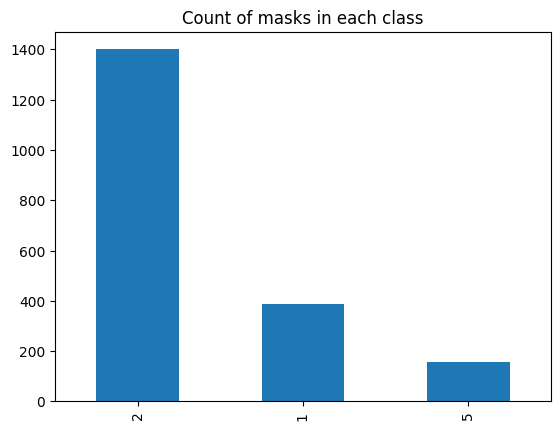

In [16]:
# Value counts of the classes in the masks

#Get the classes of the masks
masks_classes = [train_metadata[train_metadata['ID'] == mask[0]]['CLASS'].values[0] for mask in train_masks]

#Plot the classes
pd.Series(masks_classes).value_counts().plot(kind='bar')
plt.title('Count of masks in each class')
plt.show()


# Image Processing
You can use all features you'd like. A list of references describing very well-known features can be found at the end of this page but you can find many more articles in the Literature. You can use Pubmed, Google Scholar or simply Google to look for them.


## Image Preprocessing

## Segmentation

### U net Segmentation

In [7]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [18]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   
   # Reshape the mask to add a channel dimension
   input_mask = tf.reshape(input_mask, (input_mask.shape[0], input_mask.shape[1], 1))
   # Resize the mask
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   # Reshape the mask back to remove the channel dimension
   #input_mask = tf.squeeze(input_mask, axis=-1)
   return input_image, input_mask
   

def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)

       # Reshape the mask to add a channel dimension
       input_mask = tf.reshape(input_mask, (input_mask.shape[0], input_mask.shape[1], 1))
       input_mask = tf.image.flip_left_right(input_mask)
       #input_mask = tf.squeeze(input_mask, axis=-1)
   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [19]:
def load_image_train(input_image, input_mask):
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

def load_image_test(input_image, input_mask):
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

In [20]:
train_dataset = [load_image_train(image[0], image[1]) for image in train_dataset]
test_dataset = [load_image_test(image[0], image[1]) for image in test_dataset]

2024-03-30 19:53:03.451281: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36465 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2024-03-30 19:53:03.453140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 36469 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a3:00.0, compute capability: 8.0
2024-03-30 19:53:03.455179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38374 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2024-03-30 19:53:03.605722: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [21]:
#convert to tensor
aux_train_images = tf.convert_to_tensor([image[0] for image in train_dataset])
aux_train_masks = tf.convert_to_tensor([image[1]/255 for image in train_dataset])


aux_test_images = tf.convert_to_tensor([image[0] for image in test_dataset])
aux_test_masks = tf.convert_to_tensor([image[1]/255 for image in test_dataset])

In [22]:
#put in the same dataset
train_dataset = tf.data.Dataset.from_tensor_slices((aux_train_images, aux_train_masks))

test_dataset = tf.data.Dataset.from_tensor_slices((aux_test_images, aux_test_masks))


In [23]:
BATCH_SIZE = 64
BUFFER_SIZE = 100
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(300).batch(BATCH_SIZE)
test_batches = test_dataset.skip(300).take(348).batch(BATCH_SIZE)

2024-03-30 19:53:32.492117: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


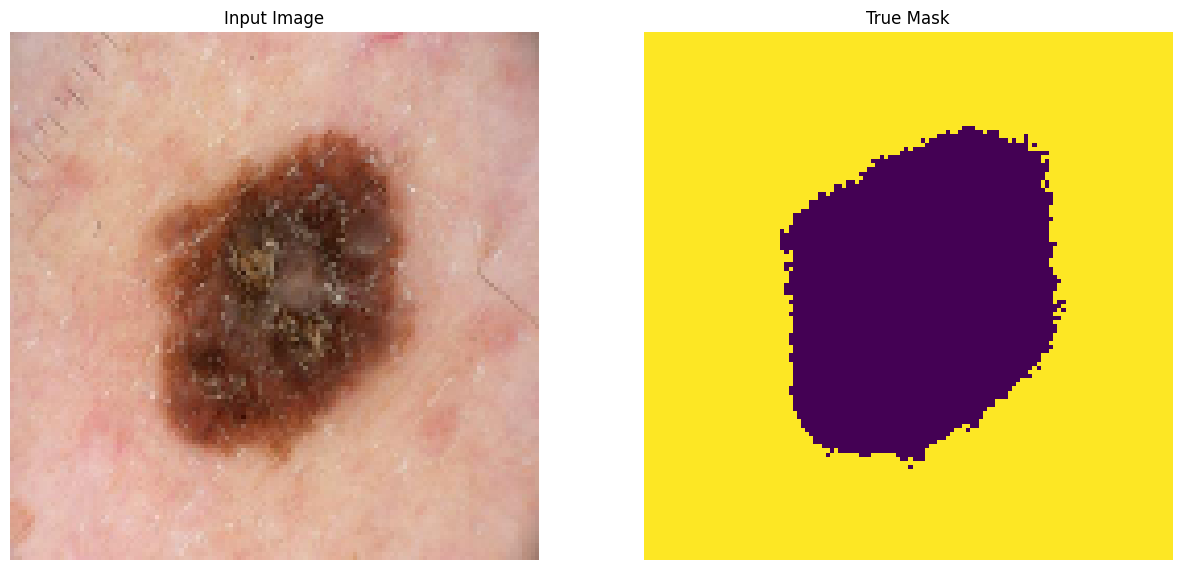

In [25]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = 0
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [8]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [27]:
def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(128,128,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [28]:
unet_model = build_unet_model()

In [29]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

In [30]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f'Error: {e}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')


In [31]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

In [33]:
NUM_EPOCHS = 30
TRAIN_LENGTH = len(train_images)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = len(test_images)
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/30


2024-03-30 19:53:57.498512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-30 19:53:57.884521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-30 19:53:57.996102: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-30 19:54:06.277453: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fca640017b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-30 19:54:06.277488: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-03-30 19:54:06.277493: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-PCIE-40GB, Comp

296/296 [==============================] - 201s 373ms/step - loss: 1.0284 - accuracy: 0.7493 - val_loss: 0.4670 - val_accuracy: 0.6783
Epoch 2/30


2024-03-30 19:57:16.353181: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2327931746610950387
2024-03-30 19:57:16.353221: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8879269963603849349
2024-03-30 19:57:16.353250: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12452231924220451565


296/296 [==============================] - 70s 237ms/step - loss: 0.3742 - accuracy: 0.7552
Epoch 3/30
296/296 [==============================] - 70s 238ms/step - loss: 0.3510 - accuracy: 0.7530
Epoch 4/30
296/296 [==============================] - 70s 237ms/step - loss: 0.3439 - accuracy: 0.7548
Epoch 5/30
296/296 [==============================] - 70s 236ms/step - loss: 0.3369 - accuracy: 0.7564
Epoch 6/30
296/296 [==============================] - 70s 236ms/step - loss: 0.3109 - accuracy: 0.7512
Epoch 7/30
296/296 [==============================] - 70s 236ms/step - loss: 0.2718 - accuracy: 0.7532
Epoch 8/30
296/296 [==============================] - 70s 236ms/step - loss: 0.2488 - accuracy: 0.7529
Epoch 9/30
296/296 [==============================] - 70s 236ms/step - loss: 0.2352 - accuracy: 0.7582
Epoch 10/30
296/296 [==============================] - 70s 236ms/step - loss: 0.2237 - accuracy: 0.7564
Epoch 11/30
296/296 [==============================] - 70s 236ms/step - loss: 0.217

In [34]:
#save the model 
unet_model.save('unet_model.h5')

/home/infres/jrios-23/miniconda3/envs/venv_cuda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Upload Model

In [17]:
# Upload the model
unet_model = tf.keras.models.load_model('unet_model.h5')

2024-04-23 10:28:36.242514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31181 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2024-04-23 10:28:36.244348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 36469 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a3:00.0, compute capability: 8.0
2024-04-23 10:28:36.246393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 17991 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [18]:
def resize_test(input_image):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_image = tf.expand_dims(input_image, axis=0)
   return input_image
   

def normalize_test(input_image):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   return input_image

def load_image_nomask_test(input_image):
   input_image = resize_test(input_image)
   input_image = normalize_test(input_image)
   return input_image

#Now try to predict the masks of the test images
def predict_mask(image):
   image_aux = load_image_nomask_test(image)
   
   pred_mask = unet_model.predict(image_aux)
   
   return pred_mask

train_images = [[image[0], image[1], predict_mask(image[1])] for image in train_images]
test_images = [[image[0], image[1], predict_mask(image[1])] for image in test_images]

2024-04-23 10:28:40.604544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-04-23 10:28:41.543010: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 35ms/step


In [19]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def resize_mask(image, mask):
   mask = tf.image.resize(mask, (image.shape[0],image.shape[1]), method="nearest")
   #delete channel dimension
   mask = tf.squeeze(mask, axis=-1)
   return mask


def postprocessing_mask(image, pred_mask):
   with tf.device('/CPU:0'):
      pred_mask = create_mask(pred_mask)
      pred_mask = resize_mask(image, pred_mask)
      pred_mask = tf.where(pred_mask == 0, 1, 0)
   return pred_mask.numpy().astype(np.uint8)


train_images = [[image[0], image[1],postprocessing_mask(image[1],image[2])] for image in train_images]
test_images = [[image[0], image[1], postprocessing_mask(image[1],image[2])] for image in test_images]
   

In [20]:
#save the mask with the image[0]+mask.png

def save_mask(image, folder):
    cv2.imwrite(f'./{folder}/{image[0]}_mask.png', image[2])
    
def joblib_save_mask(images, folder):
    return Parallel(n_jobs=-2, verbose=1)(delayed(save_mask)(image, folder) for image in images)

joblib_save_mask(train_images, 'masks_train')
joblib_save_mask(test_images, 'masks_test')

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 63 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-2)]: Done 522 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-2)]: Done 1222 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-2)]: Done 2122 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-2)]: Done 3222 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-2)]: Done 4522 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-2)]: Done 6022 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-2)]: Done 7722 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-2)]: Done 9622 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 11722 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 14022 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 16522 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 18873 out of 18998 | elapsed:  1.4min remaining:    0.6s
[Parallel(n_jobs=-2)]: Done 18998 out of 18998 | elapsed:  1.4min finished
[Paral

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### Termina UNET


## Upload Predicted Masks

In [33]:
#Upload images from folder masks_test
masks_test_filenames = os.listdir('masks_test')
masks_test_filenames = sorted(masks_test_filenames)
masks_test_predicted = []

for image in masks_test_filenames:
    masks_test_predicted.append([image[:-9], imread('masks_test/' + image)])

#Upload images from folder masks_train
masks_train_filenames = os.listdir('masks_train')
masks_train_filenames = sorted(masks_train_filenames)
masks_train_predicted = []

for image in masks_train_filenames:
    masks_train_predicted.append([image[:-9], imread('masks_train/' + image)])

In [34]:
print(len(masks_test_predicted))
print(len(test_images))

print(len(masks_train_predicted))
print(len(train_images))


6333
6333
18998
18998


In [35]:
# Add masks to train_images
for i in range(len(train_images)):
    image_name = train_images[i][0]
    mask_name = image_name + '_mask.png'
    mask_image = imread('masks_train/' + mask_name)
    train_images[i].append(mask_image)

# Add masks to test_images
for i in range(len(test_images)):
    image_name = test_images[i][0]
    mask_name = image_name + '_mask.png'
    mask_image = imread('masks_test/' + mask_name)
    test_images[i].append(mask_image)

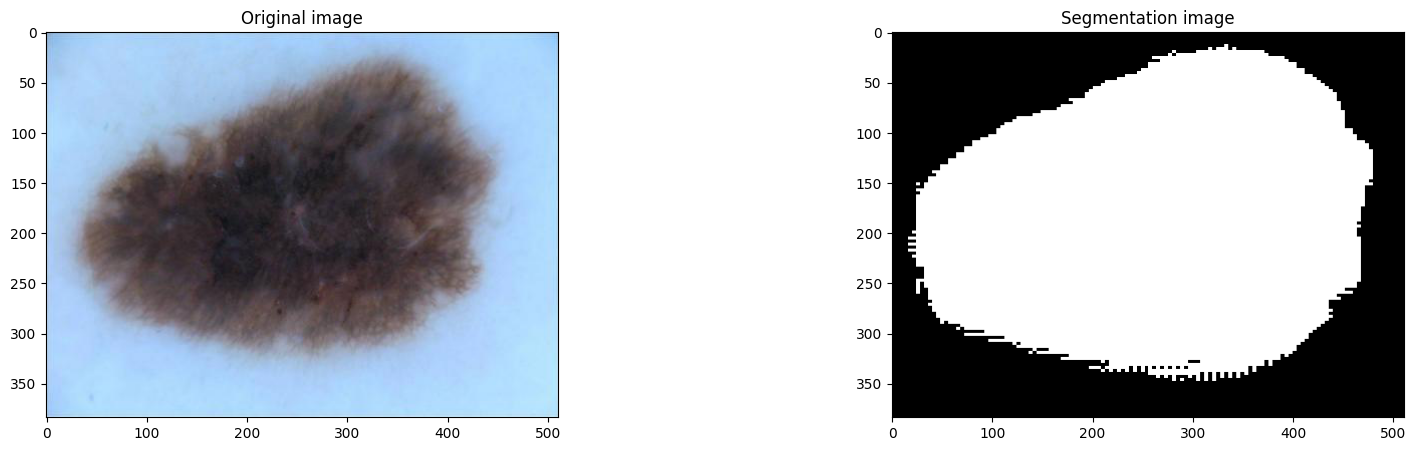

In [36]:
#plot the original image, the gray, the blur and the segmentation
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

index = 0

ax[0].imshow(train_images[index][1])
ax[0].set_title('Original image')

ax[1].imshow(train_images[index][2], cmap='gray')
ax[1].set_title('Segmentation image')

plt.show()

## Image Postprocessing

In [37]:
#morphological operations
def get_morphological_operations(image):
    # Convert the image to the appropriate data type
    image = image.astype(np.uint8)

    # Morphological closing
    kernel = np.ones((55, 55), np.uint8)
    closing = cv2.morphologyEx(image, cv2.MORPH_DILATE, kernel)

    return closing

#Apply the morphological operations to the images and different segmentations

train_images =  [
                    [   image[0], image[1], image[2],
                        get_morphological_operations(image[2]),
                    ] 
                  for image in train_images]

test_images =   [
                    [
                        image[0], image[1], image[2],
                        get_morphological_operations(image[2])
                    ] 
                  for image in test_images]

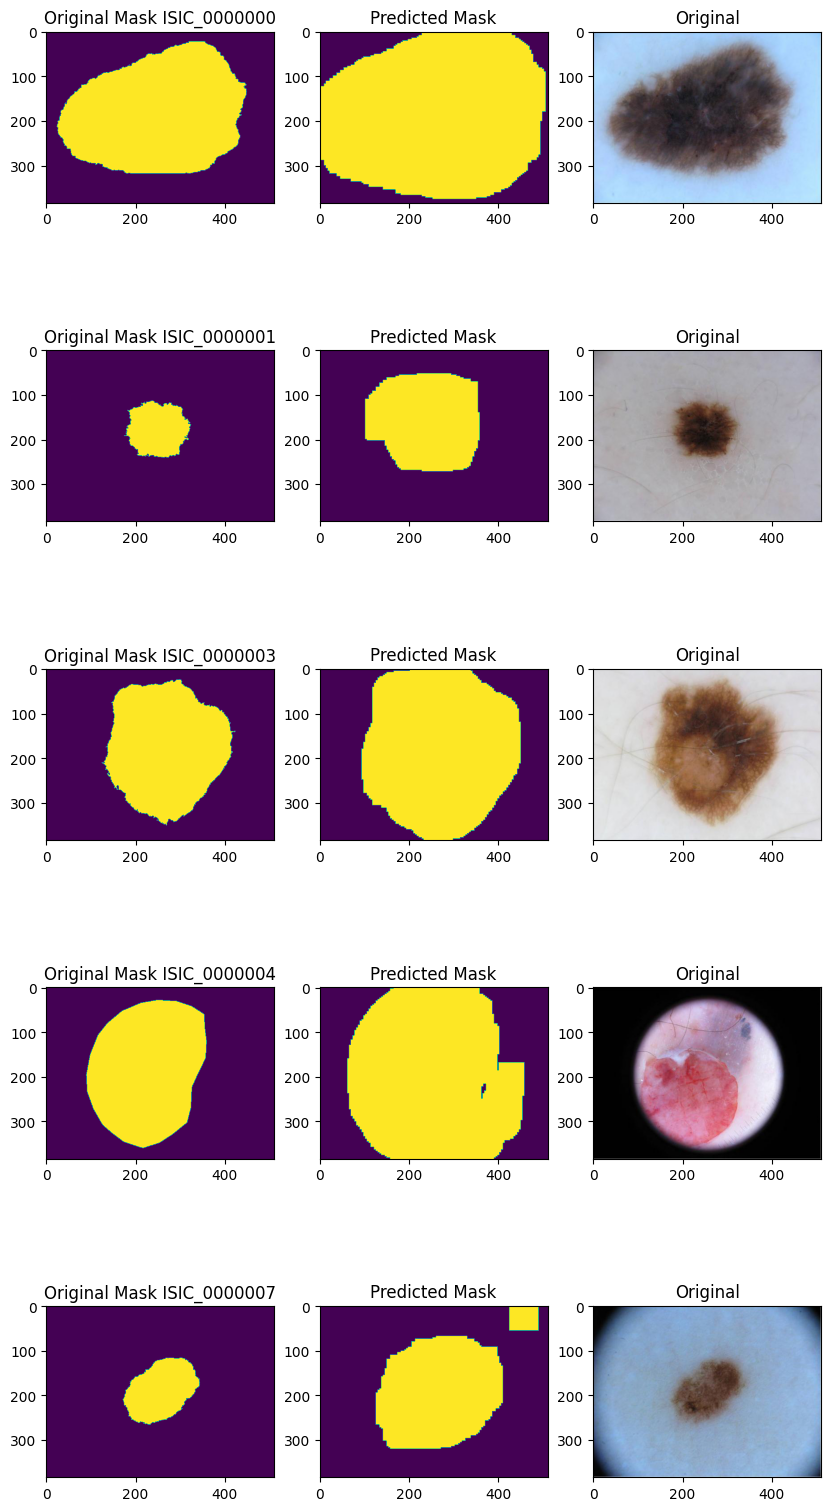

In [38]:
#comparison of the original masks and the segmented ones
fig, ax = plt.subplots(5, 3, figsize=(10, 20))

#get the first 5 masks
first_5_masks = [mask[0] for mask in train_masks[:5]]

j = 0

for i in first_5_masks:
    #Get the image
    image = next((item for item in train_images if item[0] == i), None)
    #Get the mask
    mask = next((item for item in train_masks if item[0] == i), None)
    
    #Get the class
    class_ = train_metadata[train_metadata['ID'] == i]['CLASS'].values[0]
    
    #Plot the original mask
    ax[j, 0].imshow(mask[1])
    ax[j, 0].set_title(f'Original Mask {mask[0]}')
    
    #Plot the segmented mask
    ax[j, 1].imshow(image[3])
    ax[j, 1].set_title(f'Predicted Mask')

    #Plot the segmented mask
    ax[j, 2].imshow(image[1])
    ax[j, 2].set_title(f'Original')

    j += 1

plt.show()

## Dice Coefficient

In [39]:
#GET THE IMAGE THAT ARE IN MASK AND NOT IN IMAGES
mask_images = [mask[0] for mask in train_masks]
images = [image[0] for image in train_images]

mask_images = set(mask_images)
images = set(images)

no_correspondance = mask_images - images

no_correspondance


set()

In [40]:
#Dice score between the original masks and the segmented ones
def dice_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    return 2 * intersection.sum() / (mask1.sum() + mask2.sum())

dice_scores = []
dice_scores_chan_vese = []
dice_scores_watershed = []
dice_scores_thresholding = []
dice_scores_kmeans = []

for mask in train_masks:
    
        #The image in the original mask
        mask_original = mask[1]
        mask_original[mask_original == 255] = 1
        #The segmented mask
        mask_segmented = next((item for item in train_images if item[0] == mask[0]), None)
        
    
        dice_scores.append(dice_score(mask_original, mask_segmented[2]))

for mask in test_masks:
    #The image in the original mask
    mask_original = mask[1]
    mask_original[mask_original == 255] = 1
    #The segmented mask
    mask_segmented = next((item for item in test_images if item[0] == mask[0]), None)

    dice_scores.append(dice_score(mask_original, mask_segmented[2]))

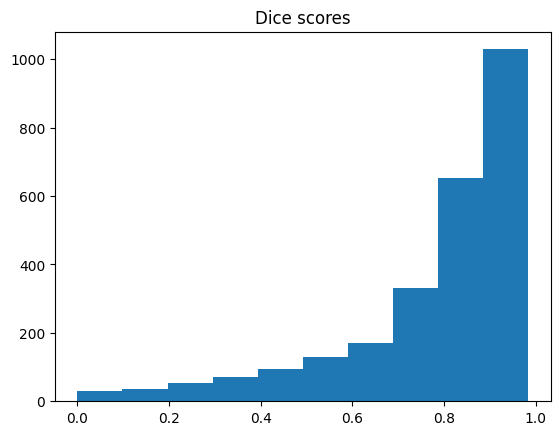

In [41]:
#Plot the dice scores
plt.hist(dice_scores)
plt.title('Dice scores')

plt.show()

In [42]:
#Mean of the dice scores
print(f'Mean Dice score: {np.mean(dice_scores)}')

#Percentage of the dice scores greater than 0.8
print(f'Percentage of Dice scores greater than 0.8: {np.mean(np.array(dice_scores) > 0.8)}')

Mean Dice score: 0.7769188378097417
Percentage of Dice scores greater than 0.8: 0.626687234863093


In [43]:
#Get the amount of dice score = 0
print(f'Amount of dice score < 0.2: {np.sum(np.array(dice_scores) < 0.2)}')

#Get the amount of dice score = 1
print(f'Amount of dice score > 0.7: {np.sum(np.array(dice_scores) > 0.7)}')


Amount of dice score < 0.2: 69
Amount of dice score > 0.7: 1977


## Border Detection

In [44]:
#Find contours in the segmented masks
def get_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

train_images =  [[image[0], image[1], image[2], get_contours(image[2])] for image in train_images]
test_images =   [[image[0], image[1], image[2], get_contours(image[2])] for image in test_images]

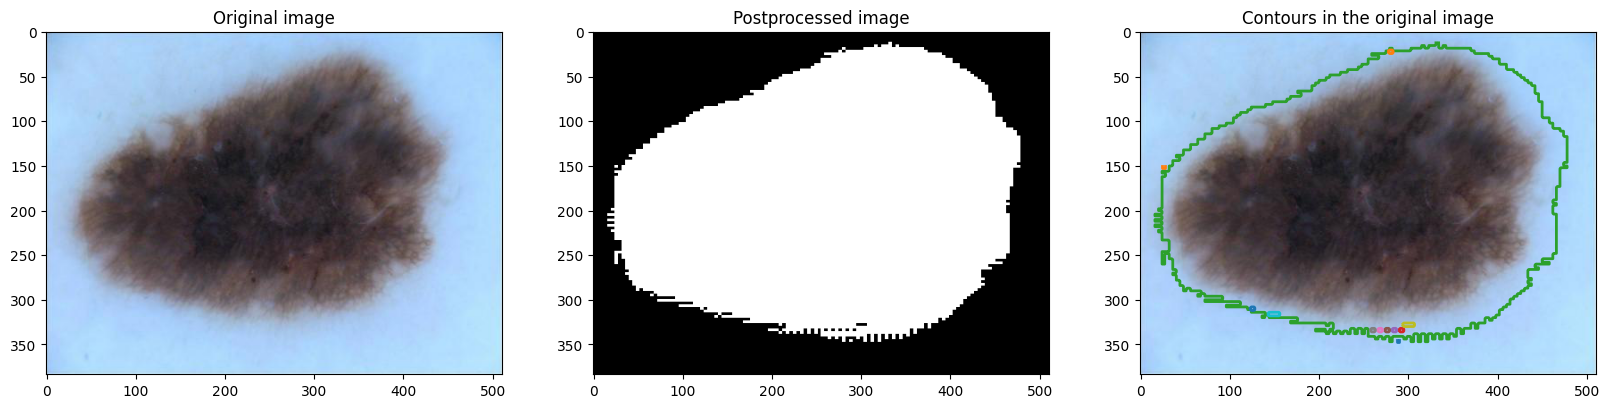

In [45]:
#Plot the original ilage, the postprocessed, and the contours in the original one
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].imshow(train_images[0][1])
ax[0].set_title('Original image')

ax[1].imshow(train_images[0][2], cmap='gray')
ax[1].set_title('Postprocessed image')

ax[2].imshow(train_images[0][1])
ax[2].set_title('Contours in the original image')
for contour in train_images[0][3]:
    ax[2].plot(contour[:, 0, 0], contour[:, 0, 1], linewidth=2)

plt.show()

Bad segmentation in train images
ISIC_0013053
()


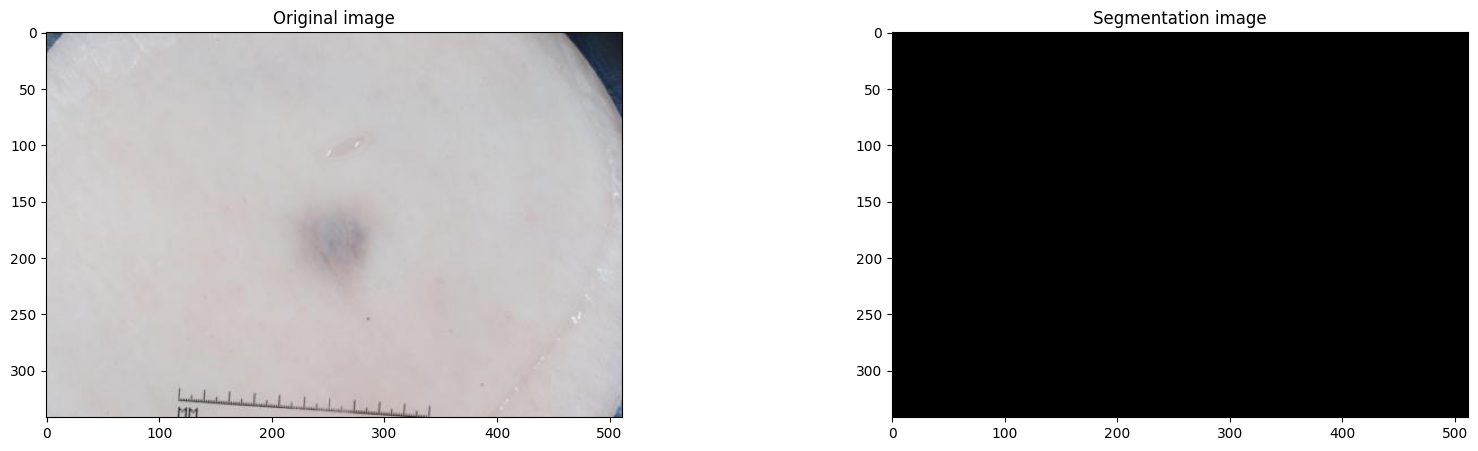

ISIC_0029150
()


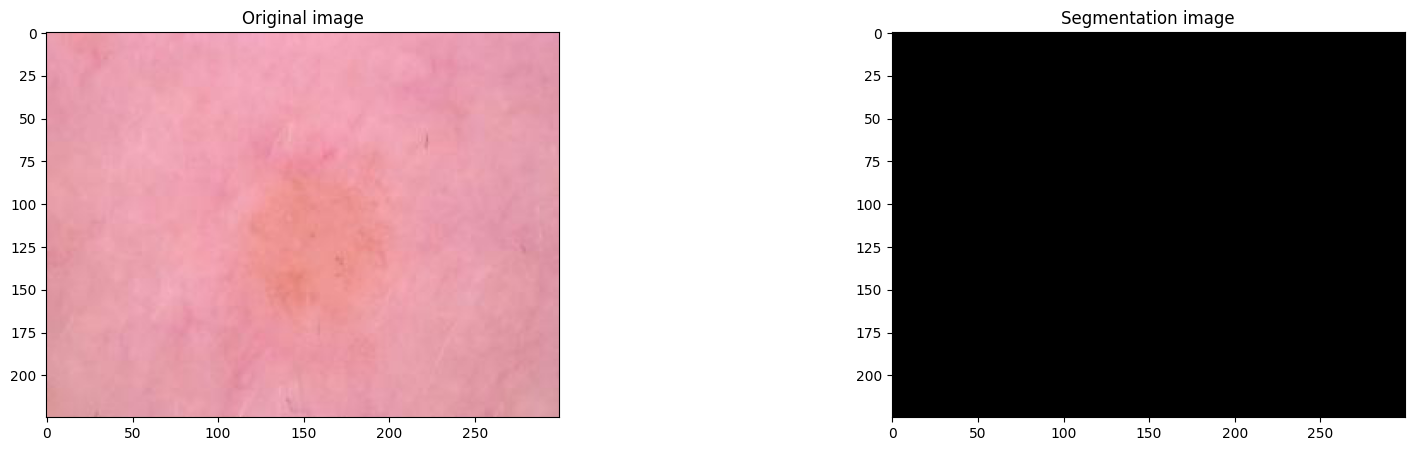

ISIC_0031072
()


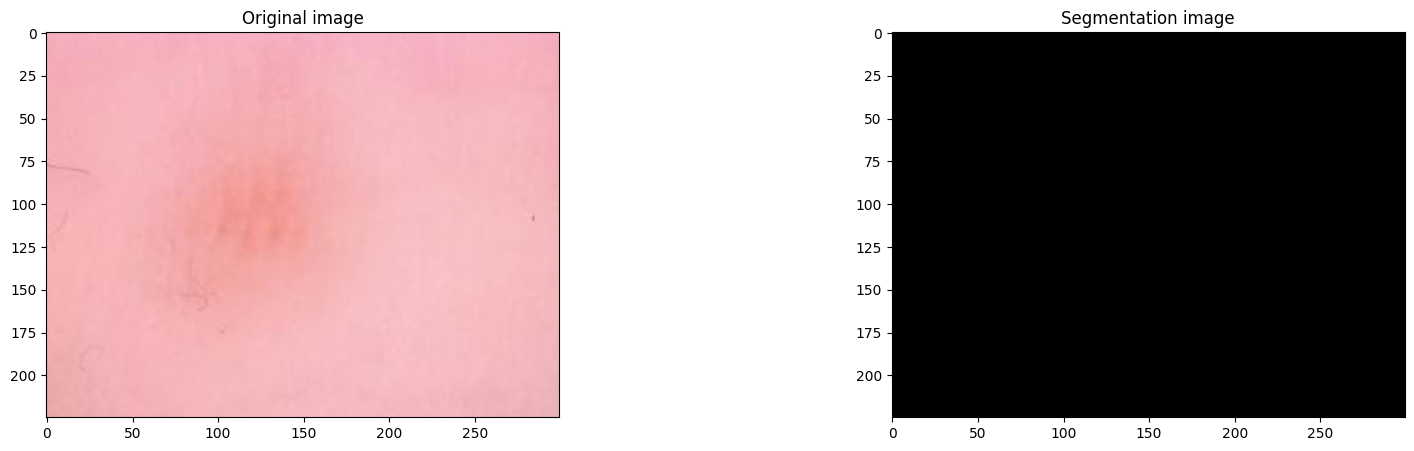

ISIC_0065207
()


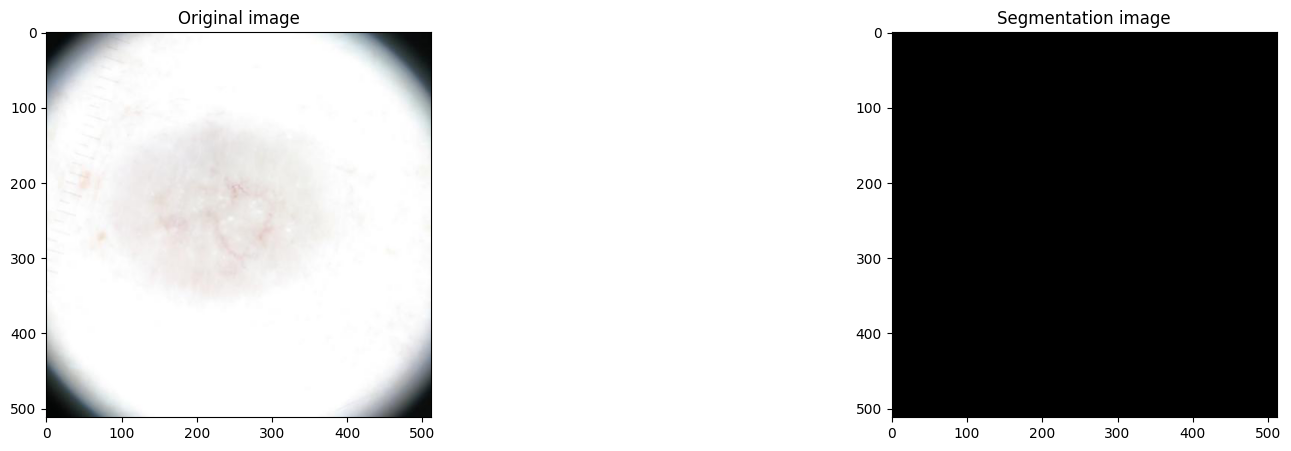

Test images with bad segmentation
ISIC_0013212
()


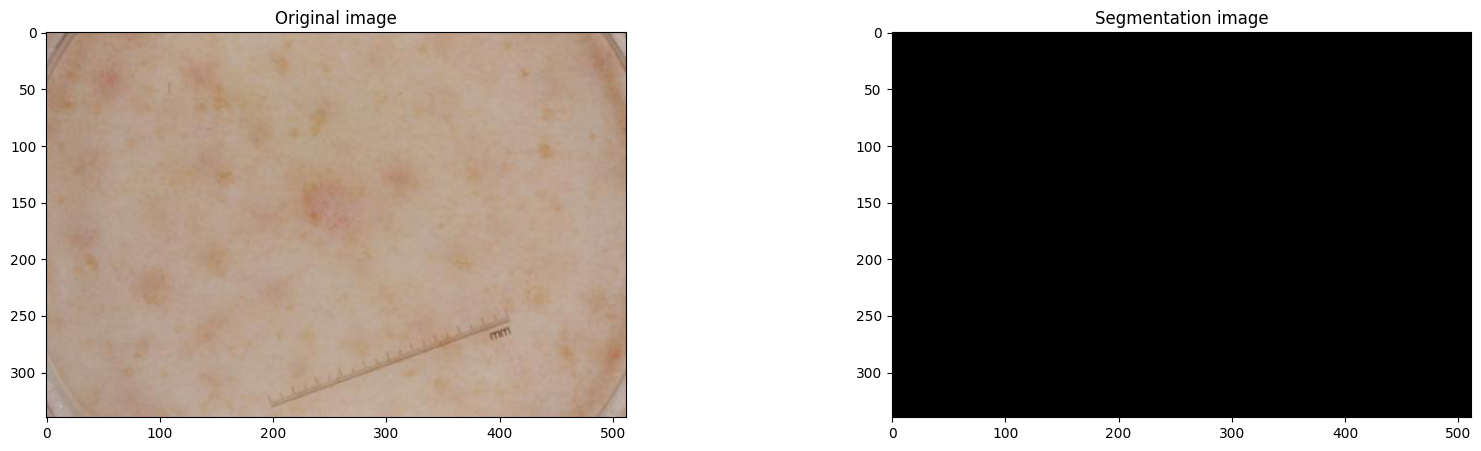

ISIC_0016031
()


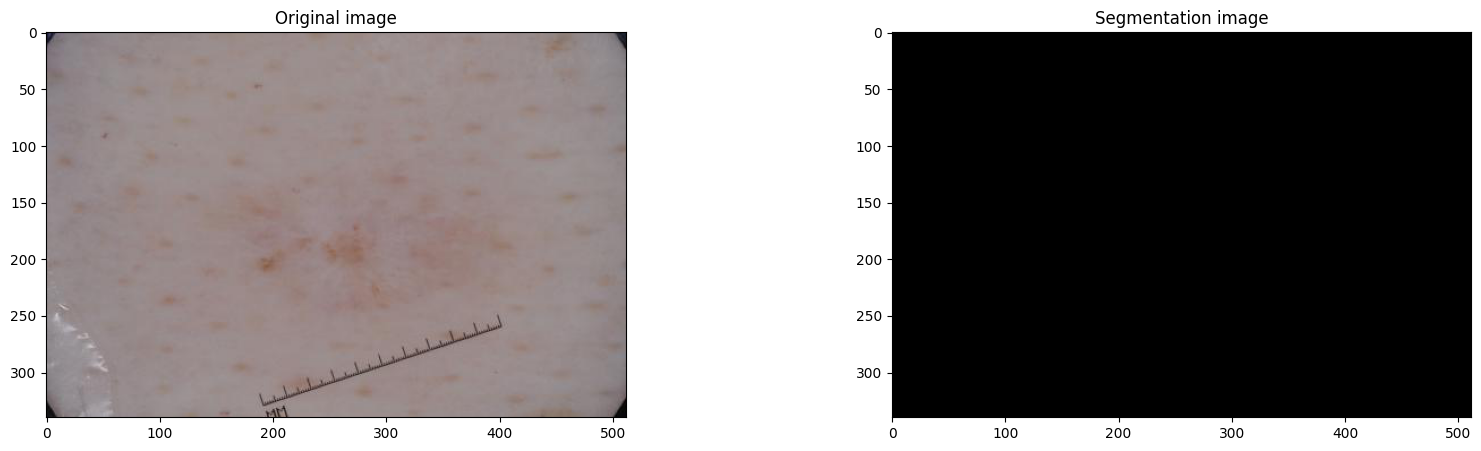

In [46]:
#Bad Segmentation in train_images
print('Bad segmentation in train images')
for image in train_images:
    if np.all(image[2] == 0):
        print(image[0])
        print(image[3])
        #display image and mask
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        ax[0].imshow(image[1])
        ax[0].set_title('Original image')
        ax[1].imshow(image[2], cmap='gray')
        ax[1].set_title('Segmentation image')
        plt.show()

#Bad Segmentation in test_images
print("Test images with bad segmentation")
for image in test_images:
    if np.all(image[2] == 0):
        print(image[0])
        print(image[3])
        #display image and mask
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        ax[0].imshow(image[1])
        ax[0].set_title('Original image')
        ax[1].imshow(image[2], cmap='gray')
        ax[1].set_title('Segmentation image')
        plt.show()
        

Bad segmentation in train images
ISIC_0016029


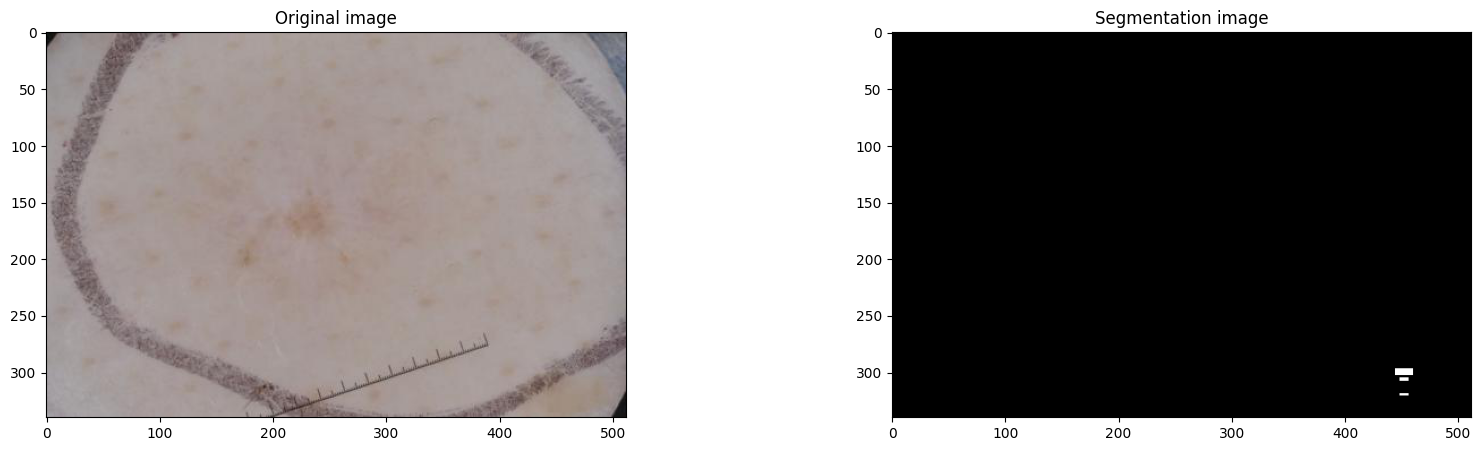

ISIC_0026238


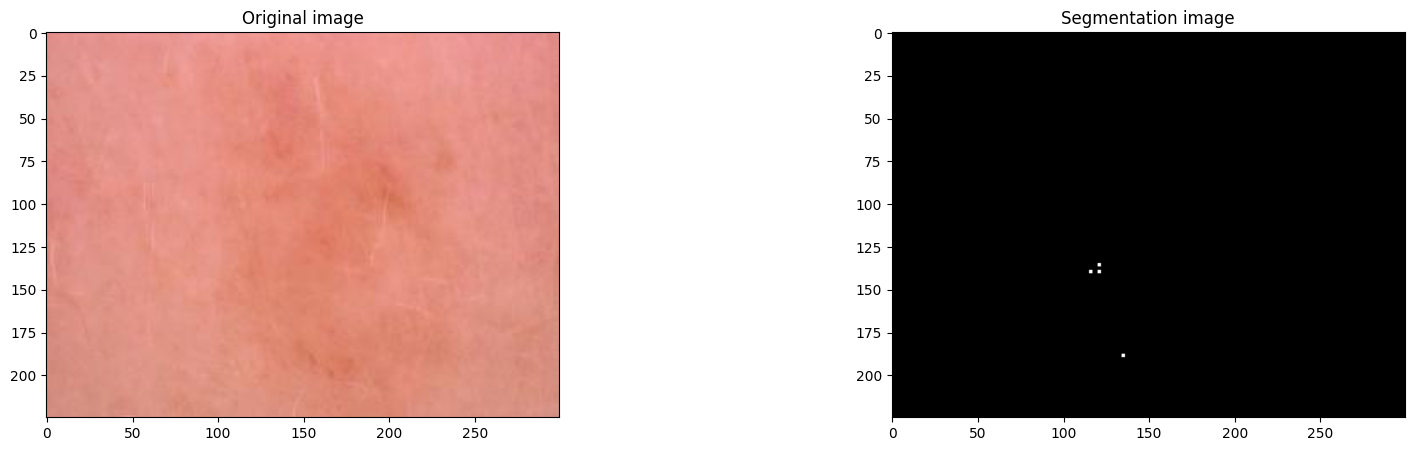

Test images with bad segmentation


In [47]:
print('Bad segmentation in train images')
for image in train_images:
    if len(image[3])>0 and len(max(image[3], key=cv2.contourArea))<5:
        print(image[0])
        #display image and mask
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        ax[0].imshow(image[1])
        ax[0].set_title('Original image')
        ax[1].imshow(image[2], cmap='gray')
        ax[1].set_title('Segmentation image')
        plt.show()


print("Test images with bad segmentation")
for image in test_images:
    if len(image[3])>0 and len(max(image[3], key=cv2.contourArea))<5:
        print(image[0])
        #display image and mask
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))
        ax[0].imshow(image[1])
        ax[0].set_title('Original image')
        ax[1].imshow(image[2], cmap='gray')
        ax[1].set_title('Segmentation image')
        plt.show()

## Feature Extraction

The ABCD rule is a method to evaluate the risk of a skin lesion being a melanoma. It is based on the following features:
- **A**symmetry
- **B**order irregularity
- **C**olour
- **D**imension

In [48]:
train_images_features = []
test_images_features = []

### Asymmetry




In [49]:
# Function to calculate the distance between two points
def distance(p1, p2):
    return np.sqrt((p1[0][0] - p2[0][0])**2 + (p1[0][1] - p2[0][1])**2)

def longest_diagonal(lesion_boundary):

    # Initialize the maximum diagonal length and coordinates
    max_diag_length = 0
    max_diag_coords = (0, 0, 0, 0)

    # Find the longest diagonal by checking distances between all pairs of points
    for i in range(len(lesion_boundary)):
        for j in range(i+1, len(lesion_boundary)):
            diag_length = distance(lesion_boundary[i], lesion_boundary[j])
            if diag_length > max_diag_length:
                max_diag_length = diag_length
                max_diag_coords = lesion_boundary[i], lesion_boundary[j]

    return max_diag_coords

def calculate_assymetry_features(image):
    try:
        # Assuming the largest contour corresponds to the lesion boundary
        # This will be a list of (row, col) coordinates of the boundary pixels
        
        lesion_boundary = max(image[3], key=len)

        # Find the longest diagonal of the lesion
        max_diag_coords = longest_diagonal(lesion_boundary)
        
        # Define the number of perpendicular lines
        N = 10
        T = len(lesion_boundary)
        P = T / N
        
        # Calculate the distances from points on the diagonal to the lesion boundary
        diagonal_length = np.linalg.norm(max_diag_coords[0] - max_diag_coords[1])
        step_size = diagonal_length / N
        distances = []
        for i in range(N):
            point_on_diagonal = max_diag_coords[0] + (max_diag_coords[1] - max_diag_coords[0]) * (i * step_size / diagonal_length)
            perp_distances = [np.linalg.norm(point_on_diagonal - contour_point) for contour_point in lesion_boundary]
            distances.append((min(perp_distances), max(perp_distances)))
        
        # Compute the features
        ratios = [d[0] / d[1] if d[1] != 0 else 0 for d in distances]
        std_dev = np.std(ratios)
        
        assymetry_features = { 'std_dev': std_dev, 'ratios': ratios}
    
        #Assymetry features in that format
        assymetry_features = { 'std_dev': std_dev }
        assymetry_features.update({ f'ratio_{i}': val for i, val in enumerate(ratios) })
        
        # Return the features in a dictionary
        return assymetry_features
    except Exception as e:
        print(image[0])
        print('Error')
        print(e)
        return None


### Border Irregularity

In [50]:
def calculate_border_irregularity_features(border):
    """
    Calculate border irregularity features based on the inflection points and vector product descriptors.
    
    :param border: A numpy array of the contour points of the lesion border.
    :return: A dictionary with counts of peaks, valleys, and straight lines for both small and large irregularities.
    """
    border = border[:, 0, :]
        
    # Initialize the counts for small irregularities
    small_irregularities = {'peaks': 0, 'valleys': 0, 'straight_lines': 0}

    # Initialize the counts for large irregularities
    large_irregularities = {'peaks': 0, 'valleys': 0, 'straight_lines': 0}

    # Inflection point descriptor parameters
    T1 = 2
    T2 = -2

    # Calculate small irregularities based on inflection points
    for i in range(1, len(border) - 1):
        # Get the neighbors
        left_neighbor = border[i - 1]
        right_neighbor = border[i + 1]

        # Calculate the weights (y-axis difference)
        Wl = left_neighbor[1] - border[i][1]
        Wr = right_neighbor[1] - border[i][1]

        # Sum the weights
        S = Wl + Wr

        # Determine if it's a peak, valley, or straight line based on the weight sum
        if S > T1:
            small_irregularities['peaks'] += 1
        elif S < T2:
            small_irregularities['valleys'] += 1
        else:
            small_irregularities['straight_lines'] += 1

    # Function to calculate vector product V for three points p1, p2, p3
    def vector_product(p1, p2, p3):
        (x1, y1), (x2, y2), (x3, y3) = p1, p2, p3
        return (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)

    # Calculate large irregularities based on vector products
    for i in range(15,len(border)-15):
        # Ensure circular indexing at the borders
        p1 = border[i - 15]
        p2 = border[i]
        p3 = border[(i + 15)]

        # Calculate the vector product
        V = vector_product(p1, p2, p3)

        # Determine if it's a peak, valley, or straight line based on vector product
        if V > 0:
            large_irregularities['peaks'] += 1
        elif V < 0:
            large_irregularities['valleys'] += 1
        else:
            large_irregularities['straight_lines'] += 1

    

    # Return the calculated features in a dictionary
    return small_irregularities, large_irregularities


### Colour

In [84]:
def calculate_color_features(img):
    """
    Calculate color features for an image in the RGB color space.
    
    :param image: RGB image as a numpy array.
    :return: A dictionary with the mean, variance, and standard deviation for each RGB channel.
    """
    image_rgb = img[1]
    mask = img[2]

    image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
    
    color_features = {}
    # Split the image into R, G, and B channels
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    
    # Calculate the mean, variance, and standard deviation for each channel
    color_features['mean_R'] = np.mean(R)
    color_features['mean_G'] = np.mean(G)
    color_features['mean_B'] = np.mean(B)
    
    color_features['variance_R'] = np.var(R)
    color_features['variance_G'] = np.var(G)
    color_features['variance_B'] = np.var(B)
    
    color_features['std_dev_R'] = np.std(R)
    color_features['std_dev_G'] = np.std(G)
    color_features['std_dev_B'] = np.std(B)
    
    return color_features

In [85]:
def calculate_color_features_hsv(img):
    color_features_hsv = {}
    
    # Convert RGB to HSI
    hsi_image = color.rgb2hsv(img[1])

    # Get the mask
    mask = img[2]

    image = cv2.bitwise_and(hsi_image, hsi_image, mask=mask)
    

    # Color features
    intensity_channel = hsi_image[..., 2]
    hue_channel = hsi_image[..., 0]

    # Intensity channel statistics
    intensity_min = np.min(intensity_channel)
    intensity_max = np.max(intensity_channel)
    intensity_mean = np.mean(intensity_channel)
    intensity_variance = np.var(intensity_channel)

    # Hue channel statistics
    hue_min = np.min(hue_channel)
    hue_max = np.max(hue_channel)
    hue_mean = np.mean(hue_channel)
    hue_variance = np.var(hue_channel)
    
    # Add the color features to the dictionary
    color_features_hsv['intensity_min'] = intensity_min
    color_features_hsv['intensity_max'] = intensity_max
    color_features_hsv['intensity_mean'] = intensity_mean
    color_features_hsv['intensity_variance'] = intensity_variance
    color_features_hsv['hue_min'] = hue_min
    color_features_hsv['hue_max'] = hue_max
    color_features_hsv['hue_mean'] = hue_mean
    color_features_hsv['hue_variance'] = hue_variance
    
    # Return the color features dictionary
    return color_features_hsv


In [86]:
#Calculate Border gradient mean and std in each RGB channel
def calculate_border_gradient_features(img):
    """
    Calculate border gradient features for an image in the RGB color space.
    
    :param image: RGB image as a numpy array.
    :return: A dictionary with the mean and standard deviation of the border gradient in each RGB channel.
    """
    border_gradient_features = {}

    image_rgb = img[1]
    mask = img[2]

    image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
    

    # Split the image into R, G, and B channels
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    
    # Calculate the gradient in each channel
    R_gradient = np.gradient(R)
    G_gradient = np.gradient(G)
    B_gradient = np.gradient(B)
    
    # Calculate the mean and standard deviation of the gradient in each channel
    border_gradient_features['mean_R_gradient'] = np.mean(R_gradient)
    border_gradient_features['mean_G_gradient'] = np.mean(G_gradient)
    border_gradient_features['mean_B_gradient'] = np.mean(B_gradient)
    
    border_gradient_features['std_dev_R_gradient'] = np.std(R_gradient)
    border_gradient_features['std_dev_G_gradient'] = np.std(G_gradient)
    border_gradient_features['std_dev_B_gradient'] = np.std(B_gradient)
    
    return border_gradient_features


### Global Features

In [87]:
def calculate_global_features(img):
    image, mask, contours = img[1],img[2],img[3]

    global_features = {}
    
    if len(contours) == 0 or len(max(contours, key=cv2.contourArea)) < 5:
        print(img[0])
        global_features['area'] = 0
        global_features['perimeter'] = 0
        global_features['circularity'] = 0
        global_features['bulkiness'] = 0
        global_features['solidity'] = 0
        return global_features
    
    contour = max(contours, key=cv2.contourArea)
    
    # Size descriptor    
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    bounding_box = cv2.boundingRect(contour)

    # Fit an ellipse to the contour
    ellipse = cv2.fitEllipse(contour)

    (a, b) = ellipse[1]  # The lengths of the semi-major and semi-minor axes
    
    area_ellipse = np.pi * (a / 2) * (b / 2)

    #Calculate circularity
    circularity = (4 * np.pi * area) / (perimeter ** 2)

    # Calculate bulkiness
    bulkiness = area_ellipse / area

    #Calculate Solidity
    hull = cv2.convexHull(contour)
    solidity = area / cv2.contourArea(hull)

    global_features['area'] = area
    global_features['perimeter'] = perimeter
    global_features['circularity'] = circularity
    global_features['bulkiness'] = bulkiness
    global_features['solidity'] = solidity

    return global_features

### Dimension

### Add features

In [89]:
def get_features(image):

    id = {'ID':image[0]}
    #assymetry_features = calculate_assymetry_features(image)
    #small_irregularities, large_irregularities = calculate_border_irregularity_features(image[3][0])
    color_features = calculate_color_features(image)
    border_gradient_features = calculate_border_gradient_features(image)
    global_features = calculate_global_features(image)
    color_features_hsv = calculate_color_features_hsv(image)
            

    # Return the features in a dictionary
    return {**id, **color_features, **border_gradient_features, **global_features, **color_features_hsv}


# train_images_features = [get_features(image) for image in train_images]
# test_images_features = [get_features(image) for image in test_images]

def joblib_features(images):
    return Parallel(n_jobs=-2, verbose=1)(delayed(get_features)(image) for image in images)

train_images_features = joblib_features(train_images)
test_images_features = joblib_features(test_images)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 127 concurrent workers.
[Parallel(n_jobs=-2)]: Done 196 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-2)]: Done 546 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-2)]: Done 996 tasks      | elapsed:   57.3s


ISIC_0013053


[Parallel(n_jobs=-2)]: Done 1546 tasks      | elapsed:   59.7s


ISIC_0016029


[Parallel(n_jobs=-2)]: Done 2196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 2946 tasks      | elapsed:  1.1min


ISIC_0026238


[Parallel(n_jobs=-2)]: Done 3796 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 4746 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 5796 tasks      | elapsed:  1.3min


ISIC_0029150


[Parallel(n_jobs=-2)]: Done 6946 tasks      | elapsed:  1.4min


ISIC_0031072


[Parallel(n_jobs=-2)]: Done 8196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 9546 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 10996 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 12546 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done 14196 tasks      | elapsed:  2.1min


ISIC_0065207


[Parallel(n_jobs=-2)]: Done 15946 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 17796 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 18998 out of 18998 | elapsed:  2.6min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 127 concurrent workers.
[Parallel(n_jobs=-2)]: Done 196 tasks      | elapsed:    1.1s


ISIC_0013212
ISIC_0016031


[Parallel(n_jobs=-2)]: Done 838 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done 1738 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-2)]: Done 2838 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-2)]: Done 4101 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-2)]: Done 4851 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-2)]: Done 5701 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-2)]: Done 6333 out of 6333 | elapsed:   29.0s finished


# Final Dataset

In [90]:
# Create a DataFrame with the calculated features and the features from the metadata
train_features_df = pd.DataFrame(train_images_features)
test_features_df = pd.DataFrame(test_images_features)

# Merge the metadata with the calculated features on ID
train_data = pd.merge(train_metadata, train_features_df, on='ID')
test_data = pd.merge(test_metadata, test_features_df, on='ID')

### Preprocessing Data

In [91]:
#Fill null age with mean
train_data['AGE'] = train_data['AGE'].fillna(train_data['AGE'].mean())
test_data['AGE'] = test_data['AGE'].fillna(test_data['AGE'].mean())


#Fill null POSITION with NO POSTION
imputer = SimpleImputer(strategy='most_frequent')
train_data['POSITION'] = pd.DataFrame(imputer.fit_transform(train_data[['POSITION']]))
train_data['SEX'] =  pd.DataFrame(imputer.fit_transform(train_data[['SEX']]))
                                          
imputer = SimpleImputer(strategy='most_frequent')                                          
test_data['POSITION'] = pd.DataFrame(imputer.fit_transform(test_data[['POSITION']]))
test_data['SEX'] = pd.DataFrame(imputer.fit_transform(test_data[['SEX']]))

#One hot encoding SEX and POSITION
train_data = pd.get_dummies(train_data, columns=['SEX','POSITION'])
test_data = pd.get_dummies(test_data, columns=['SEX','POSITION'])

#Drop the ID column
train_data = train_data.drop(columns='ID')

#### Correlation Matrix

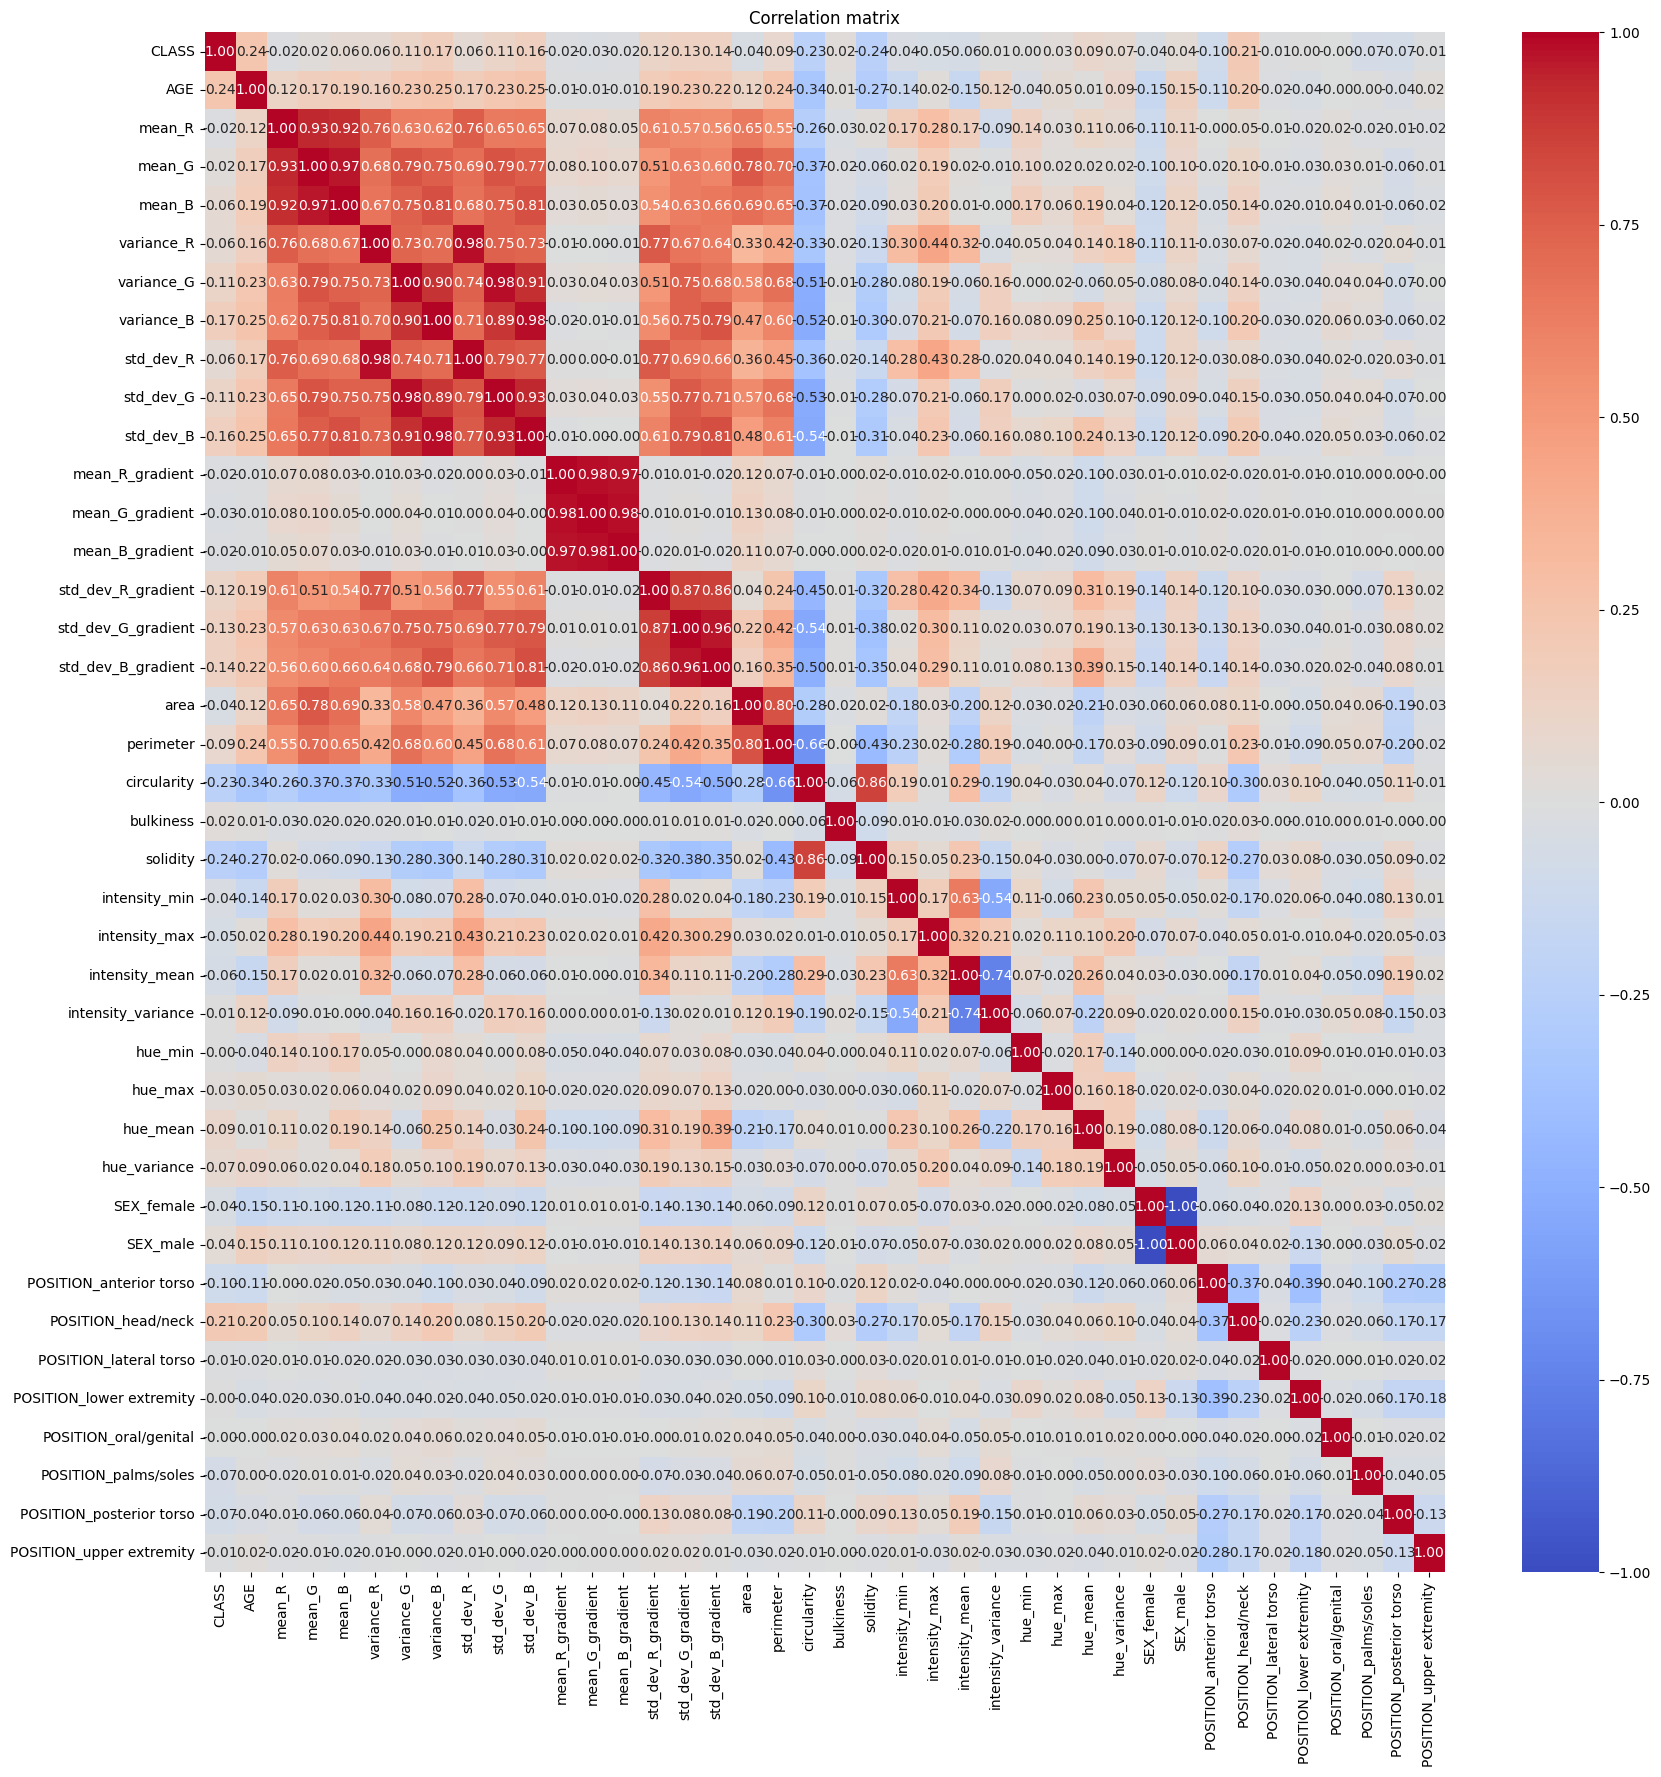

In [92]:
#Correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix')
plt.show()

#### Data Analysis

In [93]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLASS                     18998 non-null  int64  
 1   AGE                       18998 non-null  float64
 2   mean_R                    18998 non-null  float64
 3   mean_G                    18998 non-null  float64
 4   mean_B                    18998 non-null  float64
 5   variance_R                18998 non-null  float64
 6   variance_G                18998 non-null  float64
 7   variance_B                18998 non-null  float64
 8   std_dev_R                 18998 non-null  float64
 9   std_dev_G                 18998 non-null  float64
 10  std_dev_B                 18998 non-null  float64
 11  mean_R_gradient           18998 non-null  float64
 12  mean_G_gradient           18998 non-null  float64
 13  mean_B_gradient           18998 non-null  float64
 14  std_de

In [94]:
train_features_df.head()

ID     mean_R     mean_G     mean_B   variance_R   variance_G  \
0  ISIC_0000000  58.000143  57.615276  64.167186  3619.957426  4377.773516   
1  ISIC_0000001  10.550045   8.419821   7.490042  1179.867603   862.106687   
2  ISIC_0000002  61.622177  58.355155  66.240562  4769.200123  4878.466422   
3  ISIC_0000003  51.582217  38.070639  29.125739  5110.638615  3166.453909   
4  ISIC_0000004  70.376483  49.110068  59.120266  8435.670959  4421.017117   

    variance_B  std_dev_R  std_dev_G  std_dev_B  ...  bulkiness  solidity  \
0  5840.143740  60.166082  66.164745  76.420833  ...   1.043650  0.950665   
1   756.587117  34.349201  29.361653  27.506129  ...   1.151838  0.747557   
2  7057.625003  69.059396  69.846019  84.009672  ...   1.025686  0.892808   
3  2140.313033  71.488731  56.271253  46.263517  ...   1.020504  0.950580   
4  6255.842236  91.845909  66.490730  79.093882  ...   1.127279  0.833046   

   intensity_min  intensity_max  intensity_mean  intensity_variance  hue_min  \
0       0.082353       1.000000        0.675841            0.107050      0.0   
1       0.062745       0.929412        0.660551            0.011758      0.0   
2       0.000000       1.000000        0.756754            0.048881      0.0   
3       0.172549       0.984314        0.747233            0.032083      0.0   
4       0.000000       1.000000        0.359244            0.146821      0.0   

    hue_max  hue_mean  hue_variance  
0  0.993590  0.639731      0.054040  
1  0.995098  0.661680      0.067019  
2  0.996667  0.556936      0.060764  
3  0.996032  0.311865      0.098989  
4  0.998747  0.422131      0.185739  

[5 rows x 29 columns]

In [95]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  18998 non-null  object 
 1   mean_R              18998 non-null  float64
 2   mean_G              18998 non-null  float64
 3   mean_B              18998 non-null  float64
 4   variance_R          18998 non-null  float64
 5   variance_G          18998 non-null  float64
 6   variance_B          18998 non-null  float64
 7   std_dev_R           18998 non-null  float64
 8   std_dev_G           18998 non-null  float64
 9   std_dev_B           18998 non-null  float64
 10  mean_R_gradient     18998 non-null  float64
 11  mean_G_gradient     18998 non-null  float64
 12  mean_B_gradient     18998 non-null  float64
 13  std_dev_R_gradient  18998 non-null  float64
 14  std_dev_G_gradient  18998 non-null  float64
 15  std_dev_B_gradient  18998 non-null  float64
 16  area

In [96]:
train_data.describe()

CLASS           AGE        mean_R        mean_G        mean_B  \
count  18998.000000  18998.000000  18998.000000  18998.000000  18998.000000   
mean       2.568323     53.991914     50.300488     35.693553     34.370713   
std        1.532728     17.939244     32.328845     23.106008     23.356627   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000     40.000000     24.617147     17.029947     15.793389   
50%        2.000000     55.000000     45.502252     32.002109     30.369812   
75%        3.000000     70.000000     70.972374     50.942842     49.278661   
max        8.000000     85.000000    208.746044    149.696426    186.103630   

         variance_R    variance_G    variance_B     std_dev_R     std_dev_G  \
count  18998.000000  18998.000000  18998.000000  18998.000000  18998.000000   
mean    5209.153007   2897.517721   2780.509682     69.531812     51.481631   
std     2517.859245   1559.451546   1663.527890     19.351998     15.721719   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     3352.051351   1650.861403   1441.145110     57.896903     40.630794   
50%     5277.982872   2810.364051   2610.469551     72.649727     53.012867   
75%     6947.560908   4044.433053   3942.126064     83.352030     63.595857   
max    14919.733558  10081.271656  11877.612247    122.146361    100.405536   

       ...     bulkiness      solidity  intensity_min  intensity_max  \
count  ...  18998.000000  18998.000000   18998.000000   18998.000000   
mean   ...      1.200884      0.829742       0.194156       0.890112   
std    ...      2.683747      0.121357       0.193386       0.092195   
min    ...      0.000000      0.000000       0.000000       0.400000   
25%    ...      1.031718      0.757783       0.000000       0.823529   
50%    ...      1.078662      0.866205       0.149020       0.901961   
75%    ...      1.193564      0.928640       0.333333       0.972549   
max    ...    332.547915      0.992667       0.847059       1.000000   

       intensity_mean  intensity_variance       hue_min       hue_max  \
count    18998.000000        18998.000000  18998.000000  18998.000000   
mean         0.666480            0.027430      0.009836      0.981322   
std          0.147904            0.037991      0.088318      0.107461   
min          0.129949            0.000083      0.000000      0.035714   
25%          0.598320            0.003944      0.000000      0.996032   
50%          0.681895            0.010216      0.000000      0.997396   
75%          0.765661            0.031443      0.000000      0.998062   
max          0.990964            0.190600      0.943137      0.999322   

           hue_mean  hue_variance  
count  18998.000000  18998.000000  
mean       0.421449      0.092782  
std        0.299753      0.073938  
min        0.017501      0.000024  
25%        0.136126      0.021844  
50%        0.350672      0.081047  
75%        0.712124      0.155750  
max        0.974575      0.244538  

[8 rows x 30 columns]

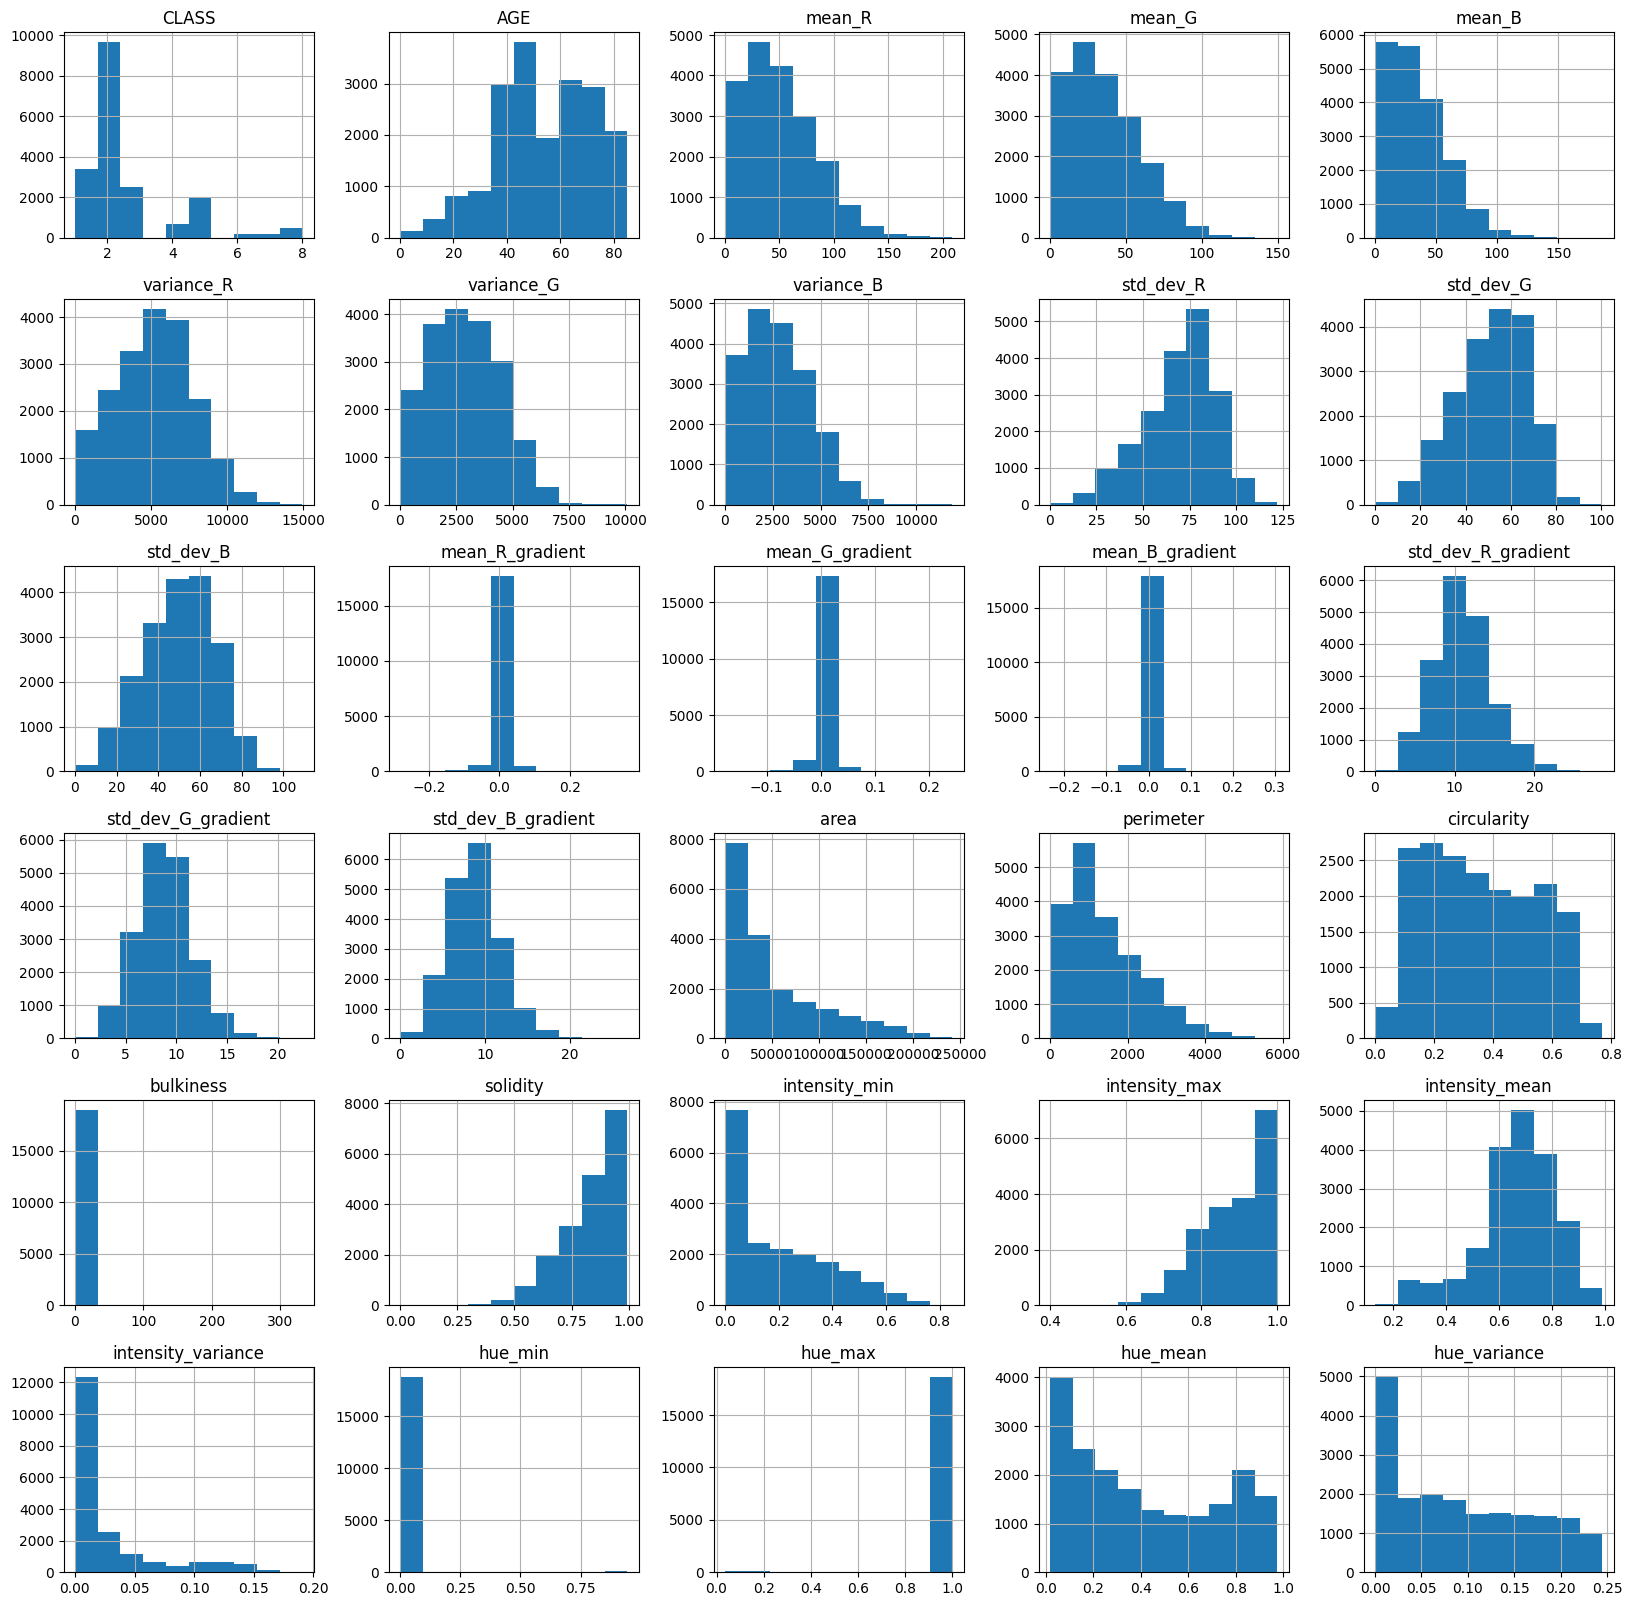

In [97]:
#Plot the histogram distribution of every variable
train_data.hist(figsize=(20, 20))
plt.show()

In [98]:
#SAVE THE DATA IN CSV
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# Classification

In [99]:
#UPLOAD THE DATA FROM CSV
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [100]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns='CLASS'), train_data['CLASS'], test_size=0.2, random_state=42)

# X_train = train_data.drop(columns='CLASS')
# y_train = train_data['CLASS']

# X_test = test_data

#Normalize and scale data
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [101]:
#Custom Scorer for the weighted accuracy
weights = {
     1:0.7005531, 
     2:0.24592265, 
     3:0.95261733, 
     4:3.64804147, 
     5:1.20674543,
     6: 13.19375,
     7: 12.56547619,
     8: 5.04219745
     }
     
def weighted_accuracy(y_true, y_pred):
    
    N = len(y_true)
    wa_sum = 0
    for i in range(N):
        if y_true.iloc[i] == y_pred[i]:
            wa_sum += weights[y_true.iloc[i]]
    return wa_sum / N

### Random Forest

In [110]:

#Random Forest

#Grid search
model_rf = RandomForestClassifier( class_weight=weights)
#param_grid = {'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2']}

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in each decision tree
    'min_samples_split': [2, 5, 10],  # Minimum number of data points placed in a node before the node is split
    'min_samples_leaf': [1, 2, 4]  # Minimum number of data points allowed in a leaf node
}

# We will use joblib to parallelize the grid search
with parallel_backend('loky', n_jobs=-1):
    grid_rf = GridSearchCV(model_rf, param_grid, refit=True, verbose=3, scoring='accuracy')
    grid_rf.fit(X_train, y_train)

print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

best_model_rf = grid_rf.best_estimator_

#Predictions
grid_predictions_rf = best_model_rf.predict(X_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.667 total time=   5.9s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.662 total time=   6.2s
[CV 2/5] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.660 total time=   6.3s
[CV 5/5] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.654 total time=   6.3s
[CV 1/5] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.655 total time=   6.4s
[CV 4/5] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.645 total time=   6.4s
[CV 2/5] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.653 total time=   6.4s
[CV 5/5] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.645 total time=   6.4s
[CV 4/5] END max_depth=None, min_sampl

In [111]:
#Print the classification report
print(classification_report(y_test, grid_predictions_rf))

#Print weighted accuracy
print(f'Weighted accuracy: {weighted_accuracy(y_test, grid_predictions_rf)}')


              precision    recall  f1-score   support

           1       0.63      0.50      0.56       670
           2       0.76      0.93      0.83      1908
           3       0.55      0.63      0.59       513
           4       0.56      0.33      0.42       135
           5       0.53      0.31      0.39       398
           6       0.67      0.05      0.10        37
           7       1.00      0.07      0.12        45
           8       0.48      0.13      0.20        94

    accuracy                           0.69      3800
   macro avg       0.65      0.37      0.40      3800
weighted avg       0.67      0.69      0.66      3800

Weighted accuracy: 0.3723729267236866


### SVM

In [104]:
#SVM
SVM = SVC(class_weight=weights)

#Grid search
param_grid = {
    'C': [1000, 10000, 50000],
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1],
}

# We will use joblib to parallelize the grid search
with parallel_backend('loky', n_jobs=-1):
    grid_svm = GridSearchCV(SVM, param_grid, verbose=3, cv=5, scoring='accuracy')
    grid_svm.fit(X_train, y_train)

print(grid_svm.best_params_)
print(grid_svm.best_estimator_)

best_model_svm = grid_svm.best_estimator_

#Predictions
grid_predictions_svm = best_model_svm.predict(X_test)


Fitting 5 folds for each of 21 candidates, totalling 105 fits


[CV 3/5] END ...............C=1000, gamma=0.001;, score=0.465 total time=  13.9s
[CV 1/5] END ...............C=1000, gamma=0.001;, score=0.468 total time=  14.2s
[CV 2/5] END ................C=1000, gamma=auto;, score=0.552 total time=  15.7s
[CV 5/5] END .............C=50000, gamma=0.0001;, score=0.483 total time=  15.7s
[CV 4/5] END ................C=1000, gamma=0.01;, score=0.539 total time=  16.3s
[CV 3/5] END ................C=1000, gamma=0.01;, score=0.556 total time=  16.8s
[CV 1/5] END ..................C=10000, gamma=1;, score=0.637 total time=  16.8s
[CV 2/5] END ..................C=10000, gamma=1;, score=0.646 total time=  17.2s
[CV 1/5] END ..............C=1000, gamma=0.0001;, score=0.424 total time=  17.4s
[CV 1/5] END ..............C=10000, gamma=0.001;, score=0.504 total time=  17.5s
[CV 1/5] END .............C=50000, gamma=0.0001;, score=0.492 total time=  18.2s
[CV 5/5] END ..............C=10000, gamma=0.001;, score=0.504 total time=  18.4s
[CV 5/5] END ...............

In [105]:
#Print the classification report
print(classification_report(y_test, grid_predictions_svm))

#Print weighted accuracy
print(f'Weighted accuracy: {weighted_accuracy(y_test, grid_predictions_svm)}')

              precision    recall  f1-score   support

           1       0.49      0.60      0.54       670
           2       0.84      0.79      0.81      1908
           3       0.61      0.58      0.59       513
           4       0.40      0.42      0.41       135
           5       0.41      0.40      0.41       398
           6       0.50      0.32      0.39        37
           7       0.64      0.31      0.42        45
           8       0.25      0.24      0.25        94

    accuracy                           0.65      3800
   macro avg       0.51      0.46      0.48      3800
weighted avg       0.66      0.65      0.65      3800

Weighted accuracy: 0.47043028137368614


# Metrics
As ranking metric, we will use the Weighted Categorization Accuracy which is defined as:
$$WA=1N∑i=1NwiI(yi=fi)$$
such that
$$∑i=1Nwi=N$$
in order to keep the maximum value equal to 1

where $y_i$ are ground truths, $f_i$ are the predicted results, and $w_i$ are the weights of the $i-th$ test image. If we make the hypothesis that we have $K$ groups - or classes - called $G={G_1,…,G_K}$ and we associate the same weight $w_t$ to all images of the same group $t$, we obtain that the weights are equal to: $w_t = \frac{ N }{ k |G_t|}$

In this way, we can take into account the imbalance nature of the data-set, if present.
Please note that the class weights in the test set are equal to: [ 0.7005531 0.24592265 0.95261733 3.64804147 1.20674543 13.19375 12.56547619 5.04219745]

In [106]:
#Calculate the weighted accuracy for every prediction to get the best model

# #SVM
print('SVM weighted Accuracy: '+ str(weighted_accuracy(y_test, grid_predictions_svm)))
# #Random Forest
print('Random Forest weighted Accuracy: '+ str(weighted_accuracy(y_test, grid_predictions_rf)))

#Select the best model
#The best model is the one with the highest weighted accuracy
models_results = [best_model_svm, best_model_rf]
results = [grid_predictions_svm, grid_predictions_rf]

best_results = results[np.argmax([weighted_accuracy(y_test, model) for model in results])]
best_model = models_results[np.argmax([weighted_accuracy(y_test, model) for model in results])]

print("\n BEST MODEL : ")
print(best_model)

best_model.fit(X_train, y_train)

SVM weighted Accuracy: 0.47043028137368614
Random Forest weighted Accuracy: 0.429467658192107

 BEST MODEL : 
SVC(C=50000,
    class_weight={1: 0.7005531, 2: 0.24592265, 3: 0.95261733, 4: 3.64804147,
                  5: 1.20674543, 6: 13.19375, 7: 12.56547619, 8: 5.04219745},
    gamma=0.1)


SVC(C=50000,
    class_weight={1: 0.7005531, 2: 0.24592265, 3: 0.95261733, 4: 3.64804147,
                  5: 1.20674543, 6: 13.19375, 7: 12.56547619, 8: 5.04219745},
    gamma=0.1)

In [112]:
#predictions for test_data
test_predictions = best_model_rf.predict(test_data.drop(columns='ID'))

#Now I need to put every prediction to the according ID that has in the test data
test_predictions = pd.DataFrame(test_predictions, columns=['CLASS'])
test_predictions = pd.concat([test_data['ID'], test_predictions], axis=1)

#save the predictions
pd.DataFrame(test_predictions, columns=['ID','CLASS']).to_csv('submission.csv', index=False)

/home/infres/jrios-23/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


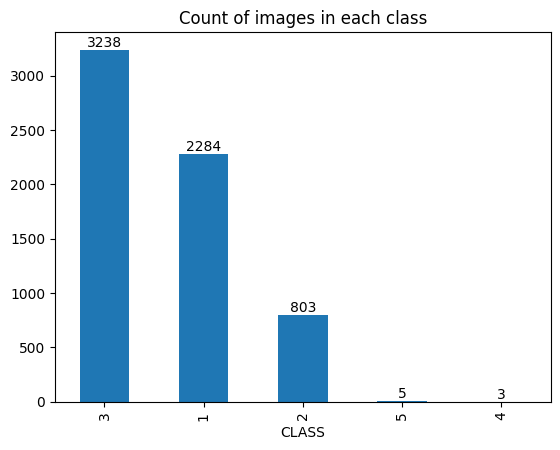

In [113]:
#Plot test predictions hist of classes
# Value counts of the classes
class_counts = test_predictions['CLASS'].value_counts()
class_counts.plot(kind='bar')

# Add legend
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Count of images in each class')
plt.show()


# Convolutional Neural Networks

In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import time
import os
import copy

In [13]:
class CustomDataset(Dataset):
    def __init__(self, paths, labels, folder : str, transform):
        """
            paths : list of paths to the images
            labels : list of the labels (between 1 and 8)
            folder : folder containing the data
            transform : the transformation to apply
        """
        self.paths = paths
        self.labels = labels  
        self.transform = transform
        self.folder = folder
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        # choose the file
        file = self.paths[idx]
        label = self.labels[idx]-1 # as the label provided are between 1 and 8 (included)
        # open the file
        inp = Image.open(os.path.join(self.folder,file+".jpg"))
        # Apply transformation
        if self.transform :
            inp = self.transform(inp)
                
        return inp, label


In [14]:
learning_rate = 1e-5
num_epochs = 25
batch_size = 32

num_classes = 8
feature_extract = False 

split = 0.05
size_img = 256

In [15]:
df = pd.read_csv("metadataTrain.csv")
X_train, X_val, y_train, y_val = train_test_split(list(df["ID"]), list(df["CLASS"]), test_size=split, random_state=42)



img_train_transform = transforms.Compose([
        transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
        transforms.RandomRotation(90),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize((size_img,size_img)),       # resize shortest side to 256 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

img_val_transform = transforms.Compose([
        transforms.Resize((size_img,size_img)),       # resize shortest side to 256 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, './Train/Train', transform=img_train_transform)
val_dataset = CustomDataset(X_val, y_val, './Train/Train', transform=img_val_transform)


image_datasets = {'train':train_dataset, 'val':val_dataset}
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

### Select Device

In [16]:
#device = torch.device("cpu" if torch.cuda.is_available() else 'cpu')

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

print(torch.cuda.is_available())
print(device)

True
cuda


In [17]:
# Feature extracting = True -> requires_grad = False
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model = models.resnet101(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

In [18]:
model = initialize_model(num_classes, feature_extract)

model = model.to(device)

/home/infres/jrios-23/miniconda3/envs/venv_cuda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/infres/jrios-23/miniconda3/envs/venv_cuda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Parameters Model

In [19]:
params_to_update = model.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

# The parameters are optimizing
#optimizer = optim.Adam(params_to_update, lr=0.001)
#optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

optimizer = optim.Adam(
    [
        {"params": model.fc.parameters(), "lr": learning_rate},
        {"params": model.layer4.parameters(), "lr": learning_rate*10},
        {"params": model.layer3.parameters(), "lr": learning_rate},
        {"params": model.layer2.parameters(), "lr": learning_rate*0.1},
        {"params": model.layer1.parameters(), "lr": learning_rate*0.1}
    ],
    lr=learning_rate,
)

# Loss function
#criterion = nn.CrossEntropyLoss()

#to reduce the learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [20]:
# weighted loss
#weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]

# calculate weights 
counts = pd.Series(y_val).value_counts()
total = counts.sum()
classes = 8
weights = [float(total/(classes*counts[i])) for i in range(1,9)]

#weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
print(weights)

loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))


[0.6597222222222222, 0.24791231732776617, 0.95, 2.96875, 1.3970588235294117, 9.134615384615385, 13.194444444444445, 6.25]


### Train Model

In [21]:
def train_model(model, dataloaders, optimizer, criterion=loss, num_epochs=num_epochs):
    start = time.time()
    acc_val_history = []
    acc_train_history = []
    loss_train_history = []
    loss_val_history = []
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        
        print('-'*10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        
        # Each epoch's training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Do this if model is in training phase
            else:
                model.eval()    # Do this if model is in validation phase
                
            running_loss = 0
            running_corrects = 0
            
            # Iteration over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Parameter gradients are initialized to 0
                optimizer.zero_grad()
                
                # Forward Pass
                # Getting model outputs and calculating loss
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
                    # Backward pass and Optimization in training phase 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                
                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                scheduler.step()
                acc_train_history.append(epoch_acc)
                loss_train_history.append(epoch_loss)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                acc_val_history.append(epoch_acc)
                loss_val_history.append(epoch_loss)
                
    time_elapsed = time.time()
    
    print('\n\n')
    print('*'*10)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    
    return model, acc_train_history,loss_train_history,acc_val_history,loss_val_history


In [22]:
model, acc_train,loss_train,acc_val,loss_val = train_model(model, dataloaders_dict, optimizer, loss, num_epochs)

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

----------
Epoch 0/24


In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Plot the training and validation loss
plt.plot(loss_train, label='Training loss')
plt.plot(loss_val, label='Validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [ ]:
#Tensor to numpy
acc_train = [acc.cpu().numpy() for acc in acc_train]
acc_val = [acc.cpu().numpy() for acc in acc_val]


In [ ]:
# Plot the training and validation accuracy
plt.plot(acc_train, label='Training accuracy')
plt.plot(acc_val, label='Validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

### Test Model

In [ ]:
import torch
num_classes = 8
feature_extract = False

device = torch.device("cpu" if torch.cuda.is_available() else 'cpu')

print(torch.cuda.is_available())
print(device)

# Load the model
model = initialize_model(num_classes, feature_extract)
model = model.to(device)

weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
          
model.load_state_dict(torch.load('model.pth'))


True
cpu


<All keys matched successfully>

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, paths, folder, transform):
        """
            paths : list of paths to the images
            labels : list of the labels (between 1 and 8)
            
            transform : the transformation to apply
        """
        self.paths = paths
        self.folder = folder
        self.transform = transform
        
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        # choose the file
        file = self.paths[idx]
        
        # open the file
        inp = Image.open(os.path.join(self.folder,file+".jpg"))
        # Apply transformation
        if self.transform :
            inp = self.transform(inp)
                
        return inp,file

df_test = pd.read_csv("metadataTest.csv")
paths = list(df_test["ID"])

img_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = CustomTestDataset(paths, './Test/Test', transform=img_transform)


test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Set the model to evaluation mode
model.eval()

# Create empty lists to store the predictions
predictions = []
files = []

model.eval()
# Iterate over the test data
for images, file in test_dataloader:
    # Move the images to the device (e.g., GPU)
    images = images.to(device)
    
    # Forward pass through the model
    outputs = model(images)
    
    # Get the predicted labels or probabilities
    _, predicted = torch.max(outputs, 1)  # For classification
    predicted = torch.argmax(outputs, dim=1) + 1  # For multi-label classification
     
    # Append the predictions to the list
    files.extend(file)
    predictions.extend(predicted.tolist())


In [ ]:
import pandas as pd

# Convert predictions to a DataFrame
df_predictions = pd.DataFrame(predictions, columns=['CLASS'])

files = pd.Series(files, name='ID')

df_predictions = pd.concat([files, df_predictions], axis=1)

# Save DataFrame to CSV file
df_predictions.to_csv('predictions.csv', index=False)


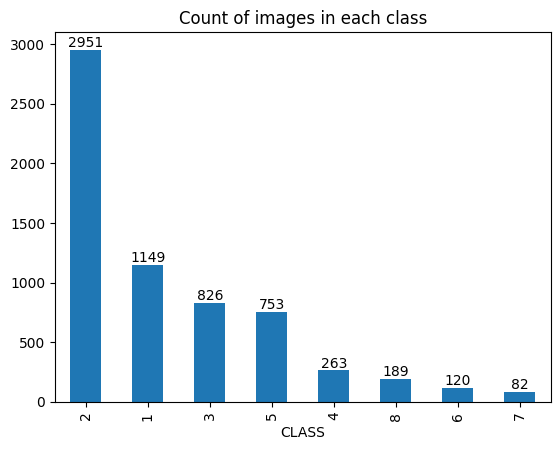

In [ ]:
#Plot test predictions hist of classes
# Value counts of the classes
import matplotlib.pyplot as plt

# Value counts of the classes
class_counts = df_predictions['CLASS'].value_counts()
class_counts.plot(kind='bar')

# Add legend
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Count of images in each class')
plt.show()


# Conclusions

# References


* http://ieeexplore.ieee.org/document/918473/
* https://www.sciencedirect.com/science/article/pii/S0933365712001108#bib0180
* https://www.sciencedirect.com/science/article/pii/S0957417416302354#bib0023
* https://www.sciencedirect.com/science/article/pii/S0933365713001589
* https://www.nature.com/articles/nature21056
* https://hal-univ-bourgogne.archives-ouvertes.fr/hal-01250955/document
* https://workshop2021.isic-archive.com/
* https://workshop2020.isic-archive.com/#paper